## Basic Models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib as plt
import seaborn as sns

In [ ]:
#YahooFinance
import yfinance as yf
symbol = 'META'

df = yf.download(symbol, period="max", interval="1d")
df.to_csv("META.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [365]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

meta = pd.read_csv("META.csv")
meta = meta[2:]
meta = meta.reset_index()
meta = meta.drop(columns=["index"])
# Rename 'Date' column in meta to 'Price', the original column name in the CSV.
meta = meta.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
meta.head()

meta[columns_to_convert] = meta[columns_to_convert].astype(float)
meta['Date'] = pd.to_datetime(meta['Date']) # Convert the 'Date' column to datetime
meta['Volume'] = meta['Volume'].astype(int)
# meta.head() # Uncomment to check the DataFrame structure

df = meta
# Now you can filter using the 'Date' column:
df = df[df['Date']>=pd.Timestamp(2020,1,1)].reset_index().drop(columns=["index"]) # Use pd.Timestamp
df = df[df['Date']<pd.Timestamp(2025,1,31)] # Use pd.Timestamp

In [ ]:
# 1. Basic Information
print("\nDataset Information:\n")
print(df.info())

# 2. Summary Statistics
print("\nSummary Statistics:\n")
print(df.describe())

# 3. Checking for Missing Values
print("\nMissing Values:\n")
print(df.isnull().sum())


Dataset Information:

<class 'pandas.core.frame.DataFrame'>
Index: 1277 entries, 0 to 1276
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1277 non-null   datetime64[ns]
 1   Close   1277 non-null   float64       
 2   High    1277 non-null   float64       
 3   Low     1277 non-null   float64       
 4   Open    1277 non-null   float64       
 5   Volume  1277 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 69.8 KB
None

Summary Statistics:

                                Date        Close         High          Low  \
count                           1277  1277.000000  1277.000000  1277.000000   
mean   2022-07-15 11:43:38.950665728   305.080172   309.187244   300.787706   
min              2020-01-02 00:00:00    88.492935    90.035660    87.676781   
25%              2021-04-09 00:00:00   209.194046   211.732110   205.979214   
50%              2022-07-15 00:0

##### XGBRegressor

In [366]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Set Date as index
df = df.set_index('Date')

# Create binary target: 1 if Close price goes up next day, else 0
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# Drop the last row with NaN from shift
df = df.dropna()

# Initialize the XGBoost Regressor
model = xgb.XGBRegressor(n_estimators=100, random_state=1)

# Define predictors and target
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Train-test split
train = df.iloc[:-100]
test = df.iloc[-100:]

# Fit the model
model.fit(train[predictors], train["Target"])

# Predict on the set
train_preds = model.predict(train[predictors])
test_preds = model.predict(test[predictors])

# Calculate metrics for training
train_mae = mean_absolute_error(train[target], train_preds)
train_rmse = np.sqrt(mean_squared_error(train[target], train_preds))
train_r2 = r2_score(train[target], train_preds)

# Calculate metrics for testing
test_mae = mean_absolute_error(test[target], test_preds)
test_rmse = np.sqrt(mean_squared_error(test[target], test_preds))
test_r2 = r2_score(test[target], test_preds)

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Root Mean Squared Error (RMSE)", "R-squared (R2)"],
    "Train": [train_mae, train_rmse, train_r2],
    "Test": [test_mae, test_rmse, test_r2]
})

# Display
print("\n📊 XGBoost Regression Evaluation Metrics:\n")
print(metrics_df)


📊 XGBoost Regression Evaluation Metrics:

                           Metric       Train        Test
0       Mean Absolute Error (MAE)  280.670355  586.089271
1  Root Mean Squared Error (RMSE)  299.579228  587.092123
2                  R-squared (R2)   -7.181312 -292.226202


In [ ]:
print(df["Target"].value_counts(normalize=True))

Target
1    0.522318
0    0.477682
Name: proportion, dtype: float64


In [362]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

Precision: 0.6470588235294118
Accuracy: 0.55
Confusion Matrix:
 [[33 12]
 [33 22]]
Unique Predictions: [0 1]


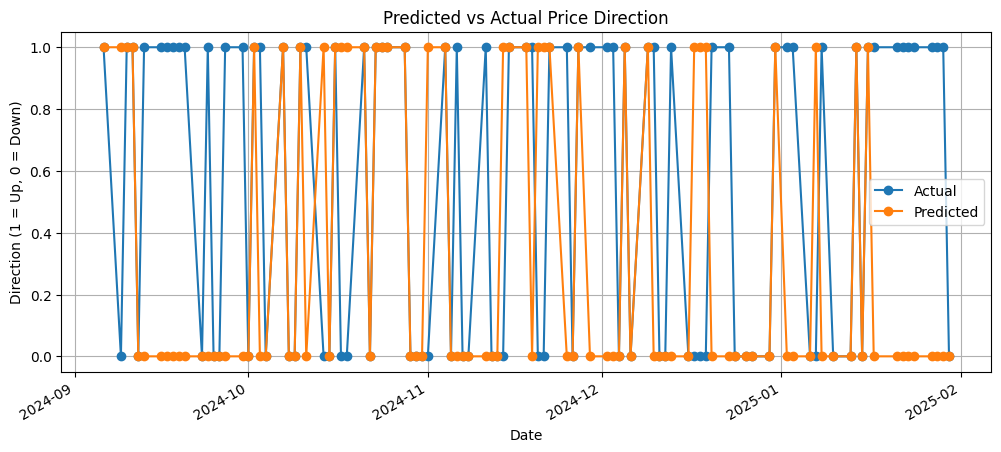

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix

# Preprocessing
# df = df.set_index('Date')

# Create binary target: 1 if price increases next day
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
df = df.dropna()

# Optional: Create new features
df["Price_Change"] = df["Close"] - df["Open"]
df["MA_3"] = df["Close"].rolling(3).mean()
df["MA_7"] = df["Close"].rolling(7).mean()
df["MA_Crossover"] = (df["MA_3"] > df["MA_7"]).astype(int)
df = df.dropna()

# Define predictors (include engineered features)
predictors = ["Volume", "Open", "High", "Low", "Price_Change", "MA_Crossover"]

# Split data
train = df.iloc[:-100]
test = df.iloc[-100:]

# Scale features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[predictors])
test_scaled = scaler.transform(test[predictors])

# Train model
model = LogisticRegression(random_state=1, max_iter=1000)
model.fit(train_scaled, train["Target"])

# Predict
preds = model.predict(test_scaled)
preds_series = pd.Series(preds, index=test.index)

# Evaluation
print("Precision:", precision_score(test["Target"], preds))
print("Accuracy:", accuracy_score(test["Target"], preds))
print("Confusion Matrix:\n", confusion_matrix(test["Target"], preds))
print("Unique Predictions:", np.unique(preds))

# Plot predictions vs actual
combined = pd.DataFrame({"Actual": test["Target"], "Predicted": preds}, index=test.index)
combined.plot(title="Predicted vs Actual Price Direction", figsize=(12, 5), marker='o')
plt.ylabel("Direction (1 = Up, 0 = Down)")
plt.grid(True)
plt.show()

##### RandomForestRegressor

In [ ]:
meta["Target"] = (meta["Close"].shift(-1) > meta["Close"]).astype(int)

In [ ]:
meta.dropna(inplace=True)

In [ ]:
meta["Date"] = pd.to_datetime(meta["Date"])
meta.set_index("Date", inplace=True)

In [352]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

train, test = df,actual
model = RandomForestRegressor(n_estimators=100, min_samples_split=100, random_state=1)
predictors = ["Close", "Volume", "Open", "High", "Low"]
predictions = []

for i in range(len(test)):

    # Retrain the model with the updated training data
    model.fit(train[predictors], train["Close"])

    # Predict the next value
    next_pred = model.predict(test.iloc[[i]][predictors])[0]
    predictions.append(next_pred)

    # Create a new row with the predicted value and the corresponding test data
    new_row = test.iloc[[i]].copy()
    new_row['Close'] = next_pred

    # Add the new row to the training data
    train = pd.concat([train, new_row], ignore_index=True)

print("Predictions:", predictions)

Predictions: [np.float64(163.8045674941328), np.float64(195.810064250727), np.float64(195.6920357625635), np.float64(195.26120379557653), np.float64(195.40047745660857), np.float64(193.71321667147495), np.float64(171.51914093913584), np.float64(163.97610145516944), np.float64(176.82249939787417), np.float64(175.11752559308533), np.float64(168.01065464526803), np.float64(164.46078405031741), np.float64(164.5811476767224), np.float64(164.5967675106718), np.float64(164.65954376499678), np.float64(164.70733180681356), np.float64(164.72875274013066), np.float64(164.6342274545959), np.float64(164.7986565436097), np.float64(164.87390977344756), np.float64(164.9019264854149), np.float64(195.6776540548417), np.float64(195.67382246096483), np.float64(195.5929077352846), np.float64(195.50408661973836), np.float64(183.84061898003048), np.float64(172.42799768896836), np.float64(182.5753862401335), np.float64(195.3106890688614), np.float64(195.3417875500214), np.float64(197.97302622902927), np.float

In [357]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Evaluate Random Forest Predictions
actual_values = test["Close"].values
predicted_values = np.array(predictions)

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

# Create DataFrame to show metrics in a table format
rf_evaluation = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'R-squared (R2)'],
    'Value': [mae, rmse, r2]
})

print("\n📊 Random Forest Evaluation Summary:\n")
print(rf_evaluation)


📊 Random Forest Evaluation Summary:

                           Metric      Value
0       Mean Absolute Error (MAE)   8.569185
1  Root Mean Squared Error (RMSE)  12.479988
2                  R-squared (R2)   0.991684


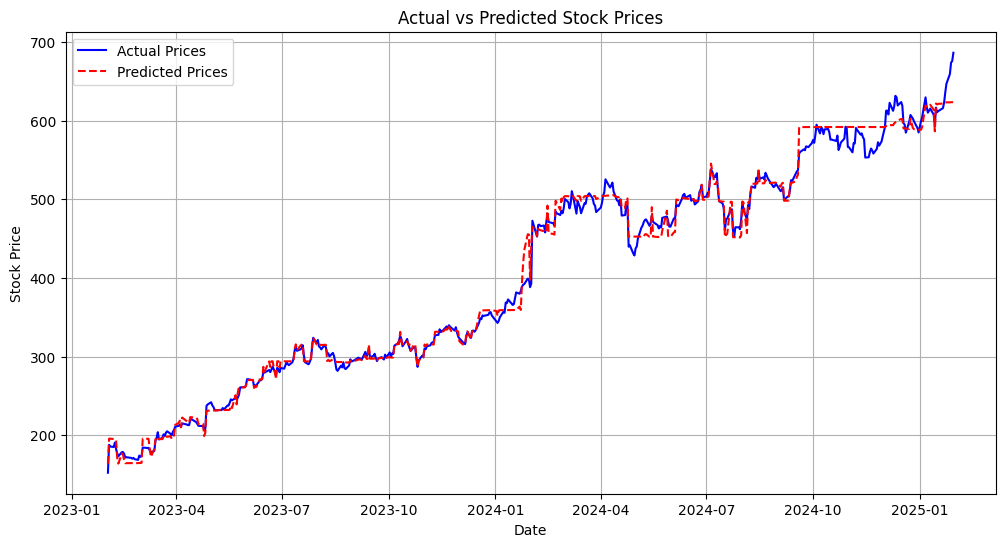

In [358]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], predictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

##### SVM Model

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

meta = pd.read_csv("META.csv")
meta = meta[2:]
meta = meta.reset_index()
meta = meta.drop(columns=["index"])
# Rename 'Date' column in meta to 'Price', the original column name in the CSV.
meta = meta.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
meta.head()

meta[columns_to_convert] = meta[columns_to_convert].astype(float)
meta['Date'] = pd.to_datetime(meta['Date']) # Convert the 'Date' column to datetime
meta['Volume'] = meta['Volume'].astype(int)
# meta.head() # Uncomment to check the DataFrame structure

df = meta
# Now you can filter using the 'Date' column:
df = df[df['Date']>=pd.Timestamp(2020,1,1)].reset_index().drop(columns=["index"]) # Use pd.Timestamp
df = df[df['Date']<pd.Timestamp(2025,1,31)] # Use pd.Timestamp

In [ ]:
df.isnull().sum()

,0
Date,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [ ]:
# Rename columns
new_columns = {col: col.replace(' ', '_').replace('Price', 'Date').replace('Week_Date', 'Day') for col in df.columns}
df = df.rename(columns=new_columns)

In [ ]:
df["Tomorrow"] = df["Close"].shift(-1)
df["Target"] = (df["Tomorrow"] > df["Close"]).astype(int)

df = df.set_index('Date')

In [ ]:
df

,Close,High,Low,Open,Volume,Tomorrow,Target
Date,,,,,,,
2020-01-02,208.795944,208.805892,205.302415,205.780159,12077100,207.691132,0
2020-01-03,207.691132,209.413012,205.979199,206.237989,11188400,211.602722,1
2020-01-06,211.602722,211.781871,205.551241,205.730389,17058900,212.060562,1
2020-01-07,212.060562,213.573436,210.756710,211.821698,14912400,214.210434,1
2020-01-08,214.210434,215.225654,211.612677,212.000846,13475000,217.275986,1
...,...,...,...,...,...,...,...
2025-01-24,646.914429,651.420429,633.636264,635.834321,19065300,659.293457,1
2025-01-27,659.293457,663.279901,624.544343,626.053010,28399200,673.730591,1
2025-01-28,673.730591,681.973257,658.883754,665.407978,20950100,675.888672,1


In [ ]:
meta = df.loc["2000-01-01":].copy()
meta

,Close,High,Low,Open,Volume,Tomorrow,Target
Date,,,,,,,
2020-01-02,208.795944,208.805892,205.302415,205.780159,12077100,207.691132,0
2020-01-03,207.691132,209.413012,205.979199,206.237989,11188400,211.602722,1
2020-01-06,211.602722,211.781871,205.551241,205.730389,17058900,212.060562,1
2020-01-07,212.060562,213.573436,210.756710,211.821698,14912400,214.210434,1
2020-01-08,214.210434,215.225654,211.612677,212.000846,13475000,217.275986,1
...,...,...,...,...,...,...,...
2025-01-24,646.914429,651.420429,633.636264,635.834321,19065300,659.293457,1
2025-01-27,659.293457,663.279901,624.544343,626.053010,28399200,673.730591,1
2025-01-28,673.730591,681.973257,658.883754,665.407978,20950100,675.888672,1


In [ ]:
meta.shape

(1277, 7)

In [ ]:
meta.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0
Tomorrow,1
Target,0



--- SVR Evaluation Summary ---
           Metric        Value
R-squared (Train)     0.924250
 R-squared (Test)    -3.747784
      MSE (Train)   376.807724
       MSE (Test) 56494.775414


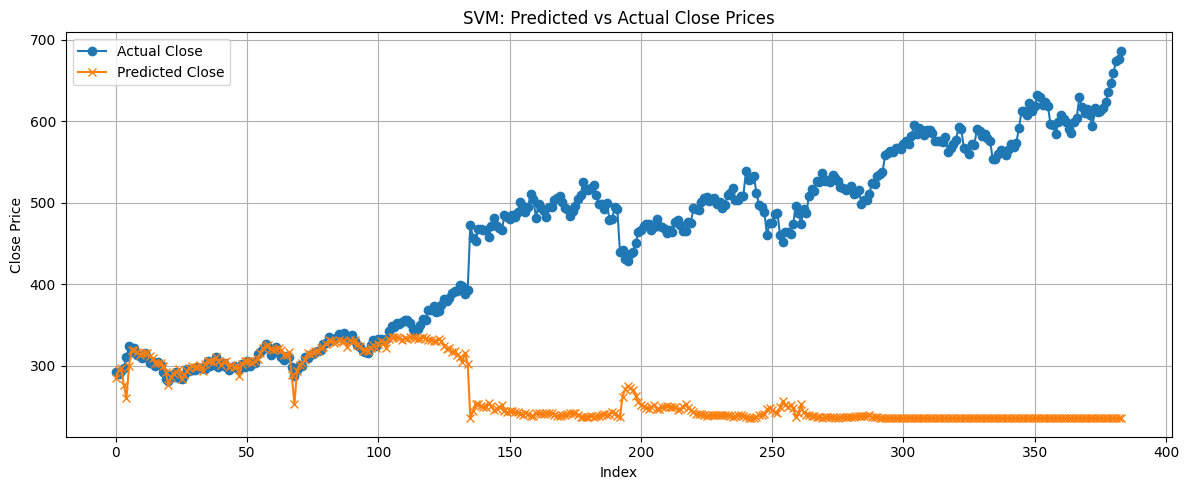

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR  # Import the SVM Regressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
features = ['High', 'Low', 'Open', 'Volume']
target = "Close"  # Set target variable as "High"

# Split the data into training (80%) and testing (20%) sets
train, test = train_test_split(meta, test_size=0.3, random_state=1, shuffle=False)

# Standardize the predictors (SVM performs better with scaled data)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Initialize the SVM model (SVR for regression)
svm_model = SVR(kernel="rbf", C=1.0, gamma="scale")

# Train the SVM model
svm_model.fit(train_scaled, train[target])

# Predict on training and testing sets
train_preds = svm_model.predict(train_scaled)
test_preds = svm_model.predict(test_scaled)

# Calculate metrics
train_r2 = r2_score(train[target], train_preds)
test_r2 = r2_score(test[target], test_preds)
train_mse = mean_squared_error(train[target], train_preds)
test_mse = mean_squared_error(test[target], test_preds)

# Create summary table
summary_df = pd.DataFrame({
    "Metric": ["R-squared (Train)", "R-squared (Test)", "MSE (Train)", "MSE (Test)"],
    "Value": [train_r2, test_r2, train_mse, test_mse]
})

# Display the summary
print("\n--- SVR Evaluation Summary ---")
print(summary_df.to_string(index=False))

# Optional: Plot predictions vs actual (Test set)
plt.figure(figsize=(12, 5))
plt.plot(test[target].values, label='Actual Close', marker='o')
plt.plot(test_preds, label='Predicted Close', marker='x')
plt.title("SVM: Predicted vs Actual Close Prices")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- SVR Evaluation Summary ---
           Metric     Value
R-squared (Train)  0.997907
 R-squared (Test)  0.985762
      MSE (Train) 10.698208
       MSE (Test) 48.687911

--- Best Hyperparameters ---
Hyperparameter  Value
             C    0.1
       epsilon    0.2
         gamma  scale
        kernel linear


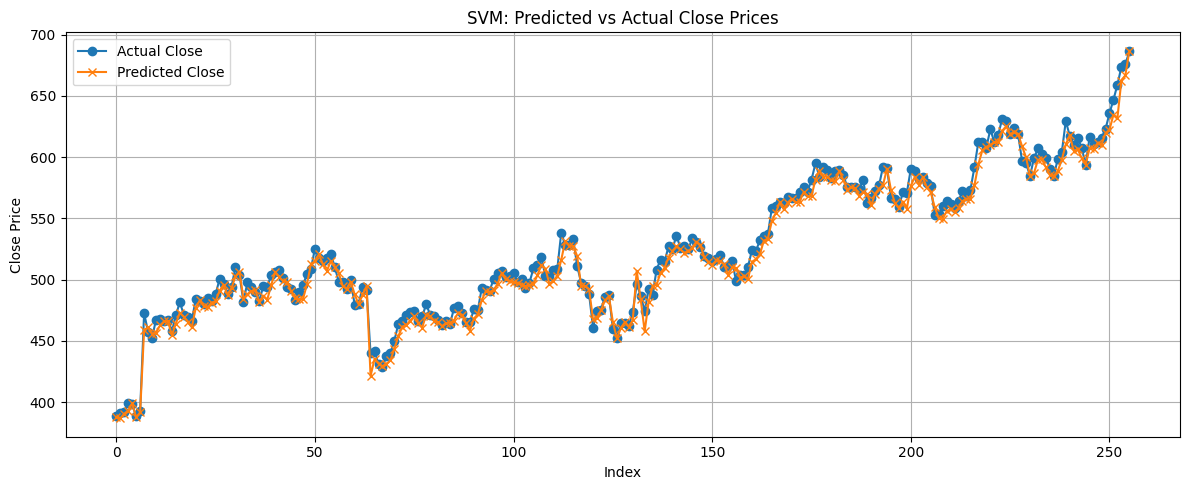

In [ ]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
features = ['High', 'Low', 'Open', 'Volume']
target = 'Close'

# Split the data
train, test = train_test_split(meta, test_size=0.2, random_state=1, shuffle=False)

# Scale the features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# GridSearchCV to tune hyperparameters
param_grid = {
    'C': [0.01, 0.1],
    'epsilon': [0.1, 0.2],
    'gamma': ['scale'],
    'kernel': ['linear']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(train_scaled, train[target])
best_params = grid_search.best_params_

# Train best model
svm_model = SVR(**best_params)
svm_model.fit(train_scaled, train[target])

# Predictions
train_preds = svm_model.predict(train_scaled)
test_preds = svm_model.predict(test_scaled)

# Evaluation Metrics
train_r2 = r2_score(train[target], train_preds)
test_r2 = r2_score(test[target], test_preds)
train_mse = mean_squared_error(train[target], train_preds)
test_mse = mean_squared_error(test[target], test_preds)

# Summary Table
summary_df = pd.DataFrame({
    "Metric": ["R-squared (Train)", "R-squared (Test)", "MSE (Train)", "MSE (Test)"],
    "Value": [train_r2, test_r2, train_mse, test_mse]
})

# Best Params Table
params_df = pd.DataFrame(list(best_params.items()), columns=["Hyperparameter", "Value"])

# Display
print("\n--- SVR Evaluation Summary ---")
print(summary_df.to_string(index=False))

print("\n--- Best Hyperparameters ---")
print(params_df.to_string(index=False))

# Optional: Plot predictions vs actual (Test set)
plt.figure(figsize=(12, 5))
plt.plot(test[target].values, label='Actual Close', marker='o')
plt.plot(test_preds, label='Predicted Close', marker='x')
plt.title("SVM: Predicted vs Actual Close Prices")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### Performing Feature Importance to see what features play a vital role and which features have less impact on the model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train a random forest model for feature importance
rf = RandomForestRegressor()
rf.fit(train[features], train[target])

# Get feature importances
importances = rf.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


  Feature  Importance
1     Low    0.797630
0    High    0.187887
2    Open    0.014274
3  Volume    0.000208


In [ ]:
pip install ta

In [ ]:
meta = meta.reset_index()  # This makes 'Date' a normal column again
print(meta['Date'])  # Now you can access 'Date' like a normal column

0      2020-01-02
1      2020-01-03
2      2020-01-06
3      2020-01-07
4      2020-01-08
          ...    
1272   2025-01-24
1273   2025-01-27
1274   2025-01-28
1275   2025-01-29
1276   2025-01-30
Name: Date, Length: 1277, dtype: datetime64[ns]


Best Parameters: {'C': 0.005, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'}

Model Evaluation Summary for SVM Model:
  Dataset  R-squared  Mean Squared Error
0   Train    -0.0111          17383.1407
1    Test    -0.0072          16698.6295


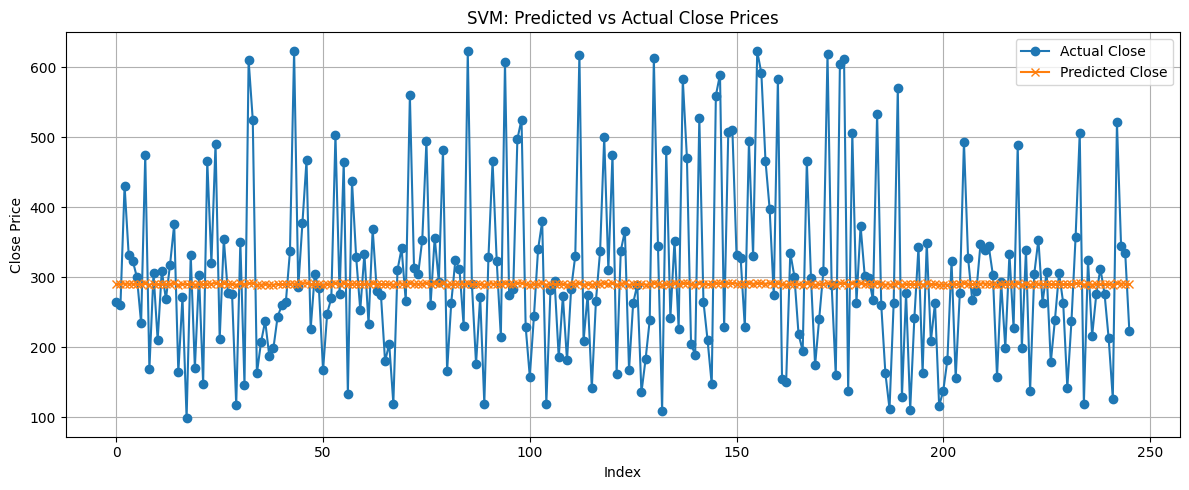

In [ ]:
import pandas as pd
import numpy as np
import ta
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
# meta = pd.read_csv("META.csv")

# Convert 'Date' to datetime and set it as index
# meta['Date'] = pd.to_datetime(meta['Date'])
# meta.set_index('Date', inplace=True) #Setting Date as the index

# Ensure data is sorted
meta = meta.sort_values("Date").reset_index(drop=True)

# Convert necessary columns to float
columns_to_convert = ["Close", "High", "Low", "Open"]
meta[columns_to_convert] = meta[columns_to_convert].astype(float)

# Add technical indicators
meta["SMA_50"] = ta.trend.sma_indicator(meta["Close"], window=50)
meta["EMA_50"] = ta.trend.ema_indicator(meta["Close"], window=50)
meta["RSI"] = ta.momentum.rsi(meta["Close"], window=14)
meta["MACD"] = ta.trend.macd(meta["Close"])

# Drop NaN values (first 50 rows will have NaNs due to SMA/EMA)
meta = meta.dropna().reset_index(drop=True)

# Define features and target
features = ['High', 'Low', 'Open', 'SMA_50', 'EMA_50', 'RSI', 'MACD']
target = 'Close'

# Split data into train (80%) and test (20%) - with shuffle enabled
train, test = train_test_split(meta, test_size=0.2, random_state=1, shuffle=True)

# Standardize features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# Hyperparameter tuning for SVR
param_grid = {
    'C': [0.001, 0.005],  # Lower regularization to avoid overfitting
    'epsilon': [0.2, 0.3],  # Prevent capturing noise
    'gamma': ['scale', 'auto'],  # Experiment with gamma selection
    'kernel': ['rbf']  # RBF kernel for non-linear patterns
}

# GridSearchCV to find best parameters
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(train_scaled, train[target])

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the SVR model with the best parameters
svm_model = SVR(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'], epsilon=best_params['epsilon'])
svm_model.fit(train_scaled, train[target])

# Predict on training and testing sets
train_preds = svm_model.predict(train_scaled)
test_preds = svm_model.predict(test_scaled)

# Calculate evaluation metrics
train_r2 = r2_score(train[target], train_preds)
test_r2 = r2_score(test[target], test_preds)

train_mse = mean_squared_error(train[target], train_preds)
test_mse = mean_squared_error(test[target], test_preds)

# Print results

# Create summary table
summary_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'R-squared': [train_r2, test_r2],
    'Mean Squared Error': [train_mse, test_mse]
})

# Round for cleaner display
summary_df = summary_df.round(4)

# Display the summary table
print("\nModel Evaluation Summary for SVM Model:")
print(summary_df)

# Optional: Plot predictions vs actual (Test set)
plt.figure(figsize=(12, 5))
plt.plot(test[target].values, label='Actual Close', marker='o')
plt.plot(test_preds, label='Predicted Close', marker='x')
plt.title("SVM: Predicted vs Actual Close Prices")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Best Parameters: {'C': 0.1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}
Summary_df for the SVM Model
              R-squared  Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
Training Set   0.996037                   3.497304                 21.540833   
Testing Set    0.979678                   5.973778                 59.186446   

              Root Mean Squared Error (RMSE)  Explained Variance Score (EVS)  
Training Set                       21.540833                        0.996038  
Testing Set                        59.186446                        0.984647  


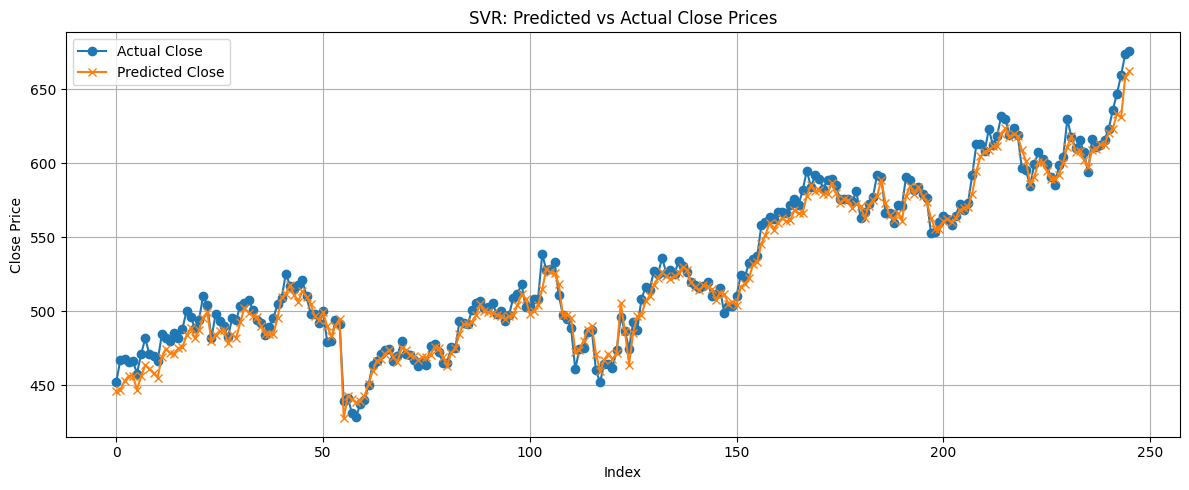

In [ ]:
import pandas as pd
import numpy as np
import ta
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.impute import SimpleImputer

# Define features and target
features = ['High', 'Low', 'Open', 'Volume', 'SMA_50', 'EMA_50']  # Use existing SMA_50 and EMA_50
target = 'Close'

# Split the data into training (80%) and testing (20%) sets
train, test = train_test_split(meta, test_size=0.2, random_state=1, shuffle=False)

# Apply SimpleImputer to handle missing values (only for features)
imputer = SimpleImputer(strategy='mean')  # Fill missing values with the mean

# Impute missing values for training and testing features
train[features] = imputer.fit_transform(train[features])
test[features] = imputer.transform(test[features])

# Standardize the predictors
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test[features])

# GridSearchCV for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1],  # Regularization parameter
    'epsilon': [0.1, 0.2],  # Epsilon in loss function
    'gamma': ['scale'],  # Gamma parameter (used in RBF kernel)
    'kernel': ['linear']  # Linear kernel (for simplicity)
}

# Perform GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(train_scaled, train[target])

# Get the best hyperparameters from the GridSearch
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model using the best parameters
svm_model = SVR(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'], epsilon=best_params['epsilon'])
svm_model.fit(train_scaled, train[target])

# Predict on the training and testing sets
train_preds = svm_model.predict(train_scaled)
test_preds = svm_model.predict(test_scaled)

# Calculate R-squared and Mean Squared Error (MSE)
train_r2 = r2_score(train[target], train_preds)
test_r2 = r2_score(test[target], test_preds)

train_mse = mean_squared_error(train[target], train_preds)
test_mse = mean_squared_error(test[target], test_preds)

# Calculate additional metrics
train_mae = mean_absolute_error(train[target], train_preds)
test_mae = mean_absolute_error(test[target], test_preds)

train_rmse = mean_squared_error(train[target], train_preds)
test_rmse = mean_squared_error(test[target], test_preds)

train_evs = explained_variance_score(train[target], train_preds)
test_evs = explained_variance_score(test[target], test_preds)

# Collecting the model evaluation metrics into a dictionary
metrics = {
    'R-squared': [train_r2, test_r2],
    'Mean Absolute Error (MAE)': [train_mae, test_mae],
    'Mean Squared Error (MSE)': [train_mse, test_mse],
    'Root Mean Squared Error (RMSE)': [train_rmse, test_rmse],
    'Explained Variance Score (EVS)': [train_evs, test_evs]
}

# Creating a DataFrame to store the summary table
summary_df = pd.DataFrame(metrics, index=['Training Set', 'Testing Set'])

# Displaying the summary table
print("Summary_df for the SVM Model")
print(summary_df)

# Optional: Plot predictions vs actual (Test set)
plt.figure(figsize=(12, 5))
plt.plot(test[target].values, label='Actual Close', marker='o')
plt.plot(test_preds, label='Predicted Close', marker='x')
plt.title("SVR: Predicted vs Actual Close Prices")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### Forecasting stock price for next 30 days

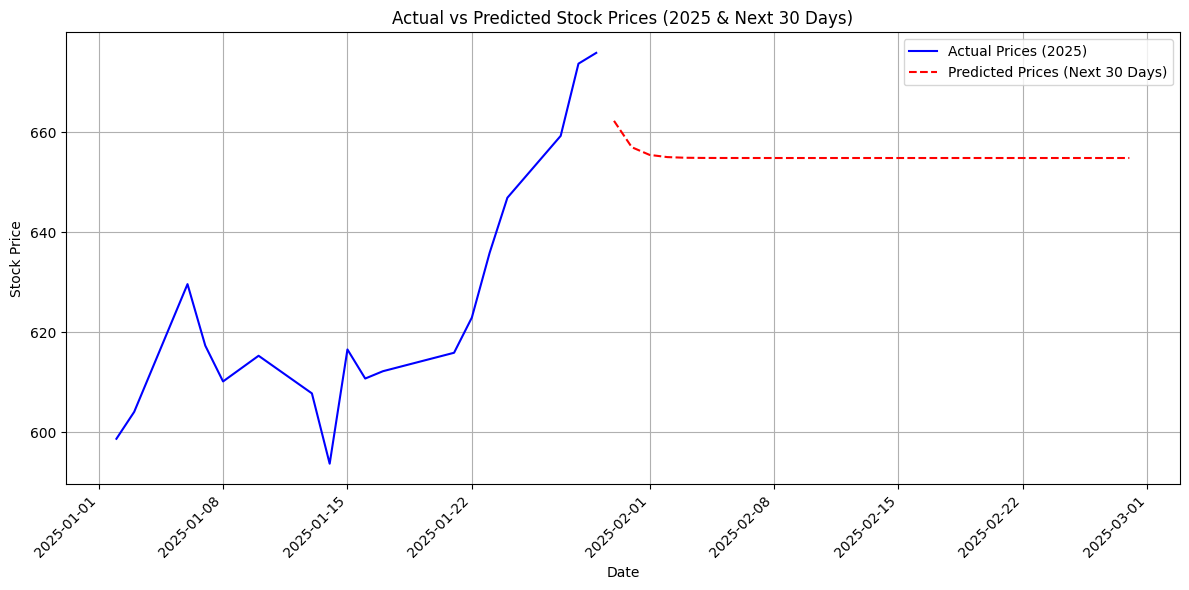

In [ ]:
# Forecasting stock price for next 30 days
# Convert 'Date' index to datetime before filtering
test['Date'] = pd.to_datetime(test['Date'])  # Convert 'Date' column to datetime
# Now you can filter by year
test_2025 = test[test['Date'].dt.year == 2025]  # Filter for the year 2025

if test_2025.empty:
    print("No data available for 2025. Please check your dataset.")
    exit()

last_data_point_2025 = test_2025.iloc[-1][features].values.reshape(1, -1)  # Convert to numpy array
last_data_point_2025 = pd.DataFrame(last_data_point_2025, columns=features)  # Ensure correct feature names

scaled_last_data_2025 = scaler.transform(last_data_point_2025)  # Now scale correctly

# Generate future predictions
future_preds = []
for _ in range(30):
    next_pred = svm_model.predict(scaled_last_data_2025)[0]
    future_preds.append(next_pred)

    # Shift the last data point with the new prediction
    last_data_point_2025[features[0]] = next_pred  # Update the 'Close' value
    scaled_last_data_2025 = scaler.transform(last_data_point_2025)  # Scale again with updated value

# Prepare future dates starting from the last date in 2025
last_date_2025 = test_2025['Date'].iloc[-1]  # Get the last date as a Timestamp
future_dates = pd.date_range(start=last_date_2025 + pd.Timedelta(days=1), periods=30, freq='D')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_2025['Date'], test_2025[target], label="Actual Prices (2025)", color='blue')
plt.plot(future_dates, future_preds, label="Predicted Prices (Next 30 Days)", color='red', linestyle='dashed')

# Format x-axis using mdates functions
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # AutoDateLocator for better tick placement
plt.xticks(rotation=45, ha='right')  # Align x-axis labels to the right

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (2025 & Next 30 Days)")
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## ARIMA MODEL

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

meta = pd.read_csv("META.csv")
meta = meta[2:]
meta = meta.reset_index()
meta = meta.drop(columns=["index"])
# Rename 'Date' column in meta to 'Price', the original column name in the CSV.
meta = meta.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
meta.head()

meta[columns_to_convert] = meta[columns_to_convert].astype(float)
meta['Date'] = pd.to_datetime(meta['Date']) # Convert the 'Date' column to datetime
meta['Volume'] = meta['Volume'].astype(int)
# meta.head() # Uncomment to check the DataFrame structure

df = meta
# Now you can filter using the 'Date' column:
df = df[df['Date']>=pd.Timestamp(2020,1,1)].reset_index().drop(columns=["index"]) # Use pd.Timestamp
df = df[df['Date']<pd.Timestamp(2025,1,31)] # Use pd.Timestamp

In [ ]:
#Order of integration: Augmented Dickey-Fuller Test
adf = adfuller(x=df['Close'], autolag='BIC')
print("The adf statistics is", format(adf[0], ".2f"))
print("The p value is",format(adf[1], ".2f"))

The adf statistics is 0.84
The p value is 0.99


Since p-value is more than 0.05 null hypothesis is rejected and the values are not stationary

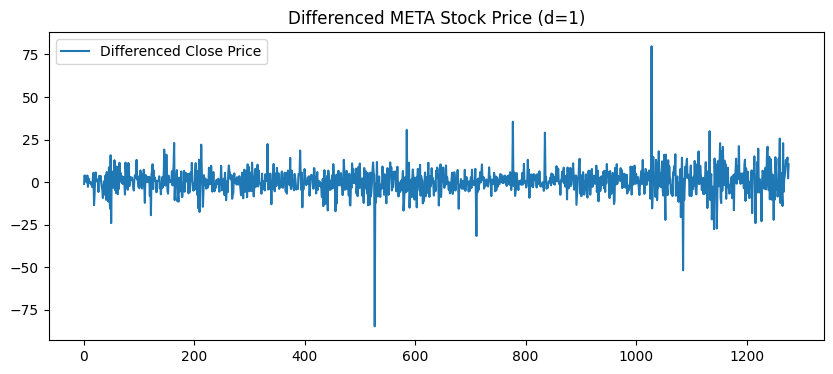

In [ ]:
df['Close_diff'] = df['Close'].diff().dropna()

# Plot differenced series
plt.figure(figsize=(10, 4))
plt.plot(df['Close_diff'], label="Differenced Close Price")
plt.title("Differenced META Stock Price (d=1)")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf,acf

Significant lags for MA component (q) in ARIMAX: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


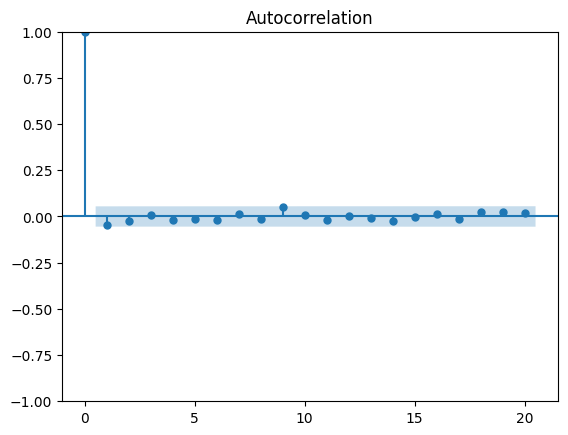

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Calculate ACF values with confidence intervals
acf_values, confint = acf(df['Close_diff'].dropna(), nlags=20, alpha=0.05)

# Compute upper and lower confidence intervals
lower_bound, upper_bound = confint[:, 0], confint[:, 1]

# Find significant lags based on confidence intervals
significant_lags = [lag for lag, value in enumerate(acf_values) if lag > 0 and (abs(value) > abs(upper_bound[lag]) or abs(value) < abs(lower_bound[lag]))]

print(f"Significant lags for MA component (q) in ARIMAX: {significant_lags}")

# Plot ACF for visualization
plot_acf(df['Close_diff'].dropna(), lags=20, alpha=0.05)
plt.show()

Significant lags for MA component (q) in ARIMAX: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


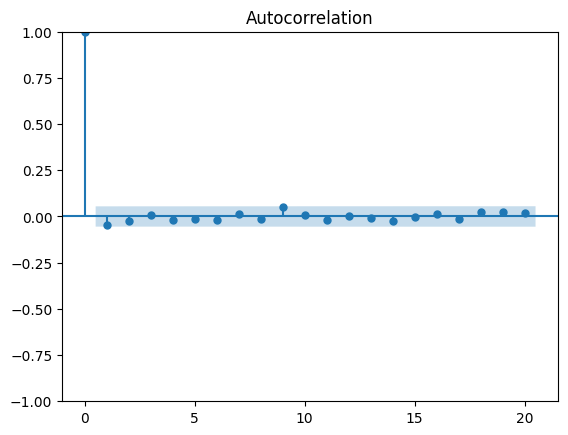

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Calculate ACF values with confidence intervals
acf_values, confint = pacf(df['Close_diff'].dropna(), nlags=20, alpha=0.05)

# Compute upper and lower confidence intervals
lower_bound, upper_bound = confint[:, 0], confint[:, 1]

# Find significant lags based on confidence intervals
significant_lags = [lag for lag, value in enumerate(acf_values) if lag > 0 and (abs(value) > abs(upper_bound[lag]) or abs(value) < abs(lower_bound[lag]))]

print(f"Significant lags for MA component (q) in ARIMAX: {significant_lags}")

# Plot ACF for visualization
plot_acf(df['Close_diff'].dropna(), lags=20, alpha=0.05)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close_diff'].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The series is stationary (p < 0.05). No need for differencing.")
else:
    print("The series is NOT stationary. Consider further differencing.")


ADF Statistic: -37.30338967539131
p-value: 0.0
The series is stationary (p < 0.05). No need for differencing.


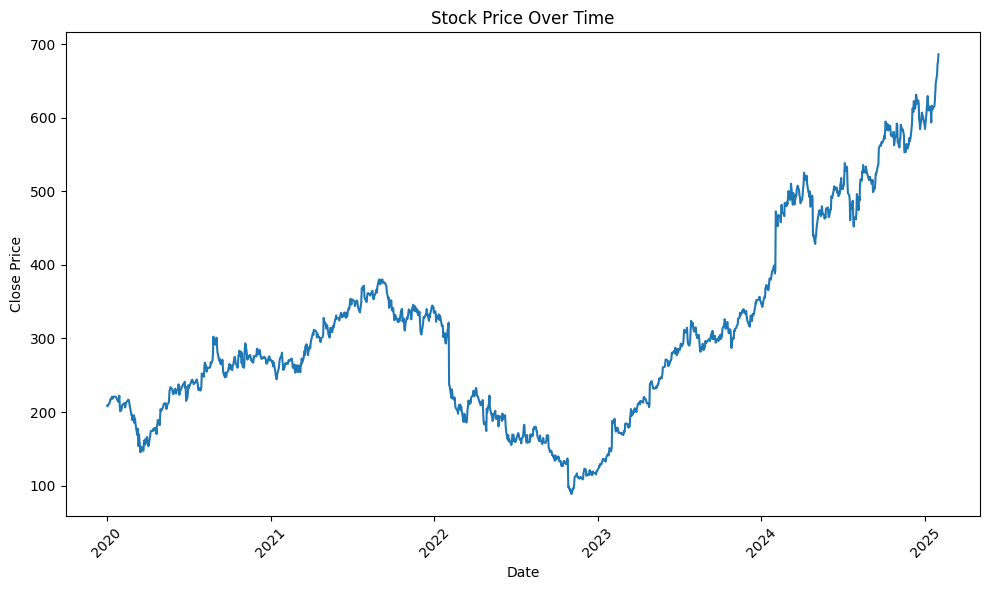

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'])  # Plot with 'Date' as the x-axis
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


#### Append approach

In [ ]:
modelpredictions = []

In [ ]:
print(list(df['Close']))

[208.79591369628906, 207.69114685058594, 211.60272216796875, 212.060546875, 214.21041870117188, 217.27597045898438, 217.03709411621094, 220.86904907226562, 218.03240966796875, 220.1125946044922, 220.72970581054688, 221.09796142578125, 220.4012451171875, 220.2818145751953, 218.72911071777344, 216.91766357421875, 213.862060546875, 216.76837158203125, 222.18284606933594, 208.547119140625, 200.96287536621094, 203.23216247558594, 208.84571838378906, 209.12440490722656, 209.86093139648438, 211.333984375, 212.060546875, 206.2180938720703, 209.7713165283203, 212.1401824951172, 213.17529296875, 216.7783203125, 216.4697723388672, 213.57342529296875, 209.19406127929688, 199.77842712402344, 195.8469696044922, 196.27493286132812, 188.85989379882812, 191.56715393066406, 195.51852416992188, 185.0179901123047, 190.8604736328125, 184.30137634277344, 180.2405242919922, 168.70489501953125, 177.35415649414062, 169.44142150878906, 153.7454071044922, 169.4812469482422, 145.3250732421875, 148.7190704345703, 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

modelpredictions = []
training_data = list(df['Close'])

# Filter data - Choose a date that exists in your dataset
actual = df[df['Date'] > pd.Timestamp(2023, 1, 31)].reset_index(drop=True)

# Initialize model_fit outside the loop
model_fit = None

for i in range(len(actual)):
    model = ARIMA(training_data, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast()
    yhat = list(forecast)[0]
    modelpredictions.append(yhat)
    actual_test = list(actual['Close'])[i]
    training_data.append(actual_test)

# Print the summary outside the loop
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1777
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7328.736
Date:                Fri, 11 Apr 2025   AIC                          14663.473
Time:                        03:50:46   BIC                          14679.919
Sample:                             0   HQIC                         14669.548
                               - 1777                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4492      0.567      0.792      0.428      -0.662       1.561
ma.L1         -0.5177      0.504     -1.027      0.304      -1.506       0.470
sigma2       224.7978      0.762    294.918      0.0

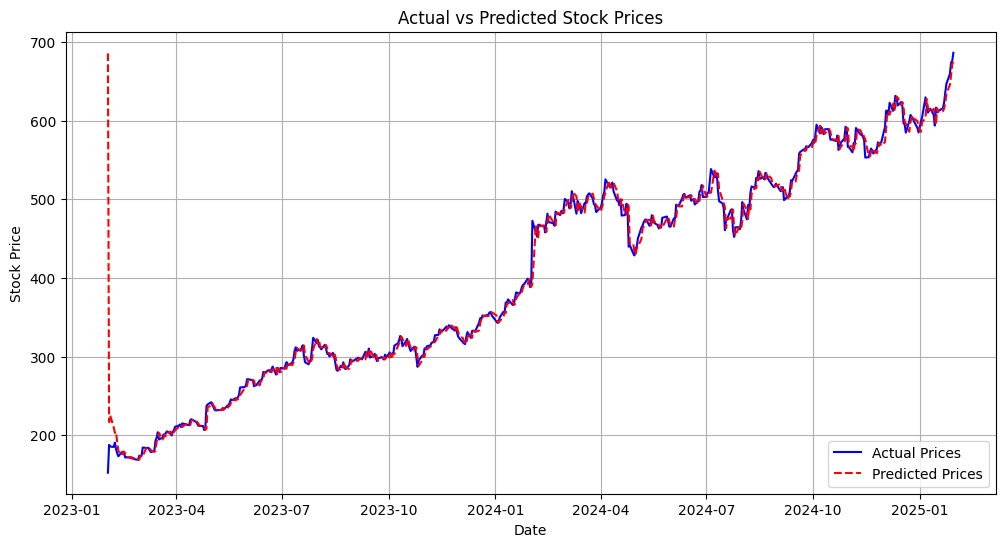

In [ ]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], modelpredictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate MAE, MSE, RMSE, and R-squared for the test set
mae_test = mean_absolute_error(actual['Close'], modelpredictions)
mse_test = mean_squared_error(actual['Close'], modelpredictions)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(actual['Close'], modelpredictions)

# For the training set:
train = df[df['Date'] <= pd.Timestamp(2023, 1, 31)]
train_predictions = model_fit.predict(start=0, end=len(train)-1) #predict on training data
#The predict function might need adjustment based on how you've defined your model

# Calculate MAE, MSE, RMSE, and R-squared for the training set
mae_train = mean_absolute_error(train['Close'], train_predictions)
mse_train = mean_squared_error(train['Close'], train_predictions)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(train['Close'], train_predictions)

# Create a summary table :
metrics = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Train': [mae_train, mse_train, rmse_train, r2_train],
    'Test': [mae_test, mse_test, rmse_test, r2_test]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Train,Test
0,MAE,4.865324,7.202944
1,MSE,102.284154,652.884324
2,RMSE,10.113563,25.551601
3,R²,0.981170,0.965141


High R² on both training (98.1%) and test data (96.5%) indicates strong model performance and excellent ability to explain variance.

MAE and RMSE are reasonable, meaning predictions are fairly accurate.

The small difference between training and test R² suggests minimal overfitting.

## SARIMA MODEL

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Set seasonal_order as (P, D, Q, s) — s = season length
seasonal_order = (1, 1, 1, 7)  # (P,D,Q,s)

modelpredictions = []
training_data = list(df['Close'])

# Define actual/test data after Jan 31, 2023
actual = df[df['Date'] > pd.Timestamp(2023, 1, 31)].reset_index(drop=True)

model_fit = None

for i in range(len(actual)):
    model = SARIMAX(training_data, order=(1, 1, 1), seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)
    yhat = forecast[0]
    modelpredictions.append(yhat)

    # Update training data with actual observed value
    training_data.append(actual['Close'][i])

# Print summary of the final fitted model
print(model_fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1777
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7285.521
Date:                           Fri, 11 Apr 2025   AIC                          14581.043
Time:                                   11:28:25   BIC                          14608.408
Sample:                                        0   HQIC                         14591.156
                                          - 1777                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4349      0.550      0.790      0.429      -0.644       1.513
ma.L1         -0.5042      0.490     -1.029

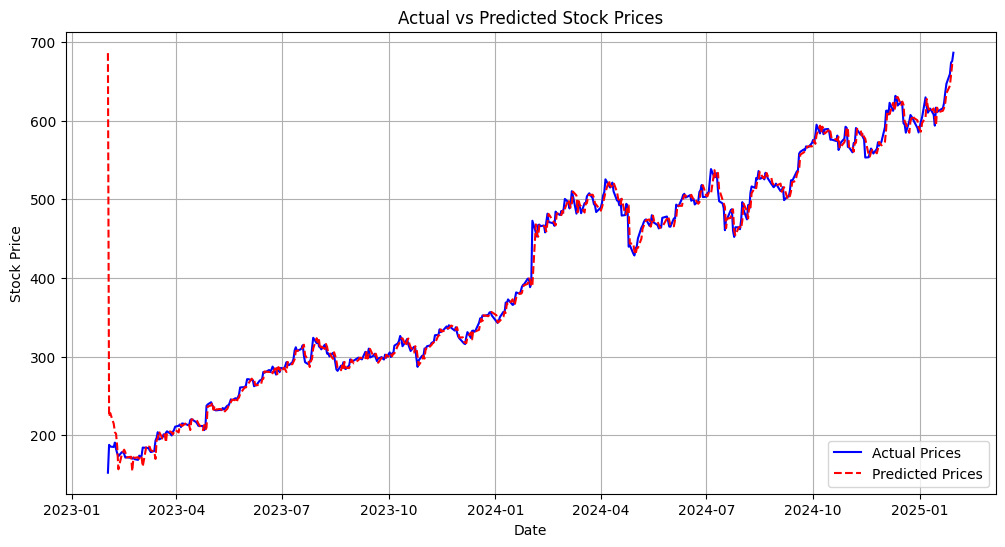

In [ ]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], modelpredictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate MAE, MSE, RMSE, and R-squared for the test set
mae_test = mean_absolute_error(actual['Close'], modelpredictions)
mse_test = mean_squared_error(actual['Close'], modelpredictions)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(actual['Close'], modelpredictions)

# For the training set:
train = df[df['Date'] <= pd.Timestamp(2023, 1, 31)]
train_predictions = model_fit.predict(start=0, end=len(train)-1) #predict on training data
#The predict function might need adjustment based on how you've defined your model

# Calculate MAE, MSE, RMSE, and R-squared for the training set
mae_train = mean_absolute_error(train['Close'], train_predictions)
mse_train = mean_squared_error(train['Close'], train_predictions)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(train['Close'], train_predictions)

# Create a summary table :
metrics = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Train': [mae_train, mse_train, rmse_train, r2_train],
    'Test': [mae_test, mse_test, rmse_test, r2_test]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Train,Test
0,MAE,5.170005,7.455355
1,MSE,129.277520,660.333293
2,RMSE,11.370027,25.696951
3,R²,0.976201,0.964744


## ARIMAX MODEL

In [370]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

meta = pd.read_csv("META.csv")
meta = meta[2:]
meta = meta.reset_index()
meta = meta.drop(columns=["index"])
# Rename 'Date' column in meta to 'Price', the original column name in the CSV.
meta = meta.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
meta.head()

meta[columns_to_convert] = meta[columns_to_convert].astype(float)
meta['Date'] = pd.to_datetime(meta['Date']) # Convert the 'Date' column to datetime
meta['Volume'] = meta['Volume'].astype(int)
# meta.head() # Uncomment to check the DataFrame structure

df = meta
# Now you can filter using the 'Date' column:
df = df[df['Date']>=pd.Timestamp(2020,1,1)].reset_index().drop(columns=["index"]) # Use pd.Timestamp
df = df[df['Date']<pd.Timestamp(2025,1,31)] # Use pd.Timestamp

In [371]:
# Perform ADF Test
result = adfuller(df['Close'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

# If p-value > 0.05, the data is non-stationary → Apply differencing

ADF Statistic: 0.9697786241285368
p-value: 0.9939366186769177


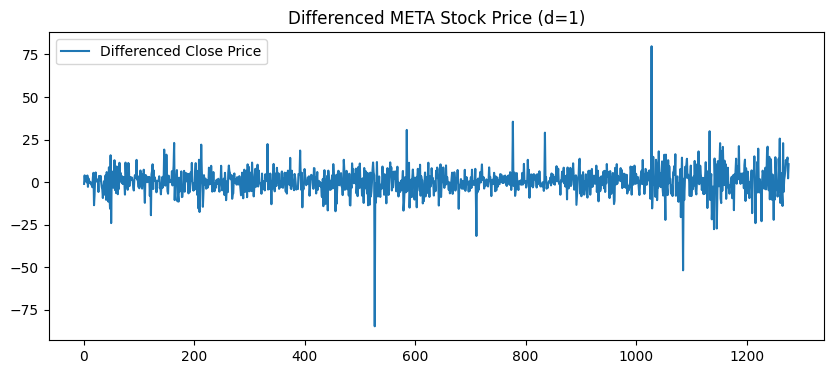

In [372]:
df['Close_diff'] = df['Close'].diff().dropna()

# Plot differenced series
plt.figure(figsize=(10, 4))
plt.plot(df['Close_diff'], label="Differenced Close Price")
plt.title("Differenced META Stock Price (d=1)")
plt.legend()
plt.show()

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf,acf

Significant lags for MA component (q) in ARIMAX: []


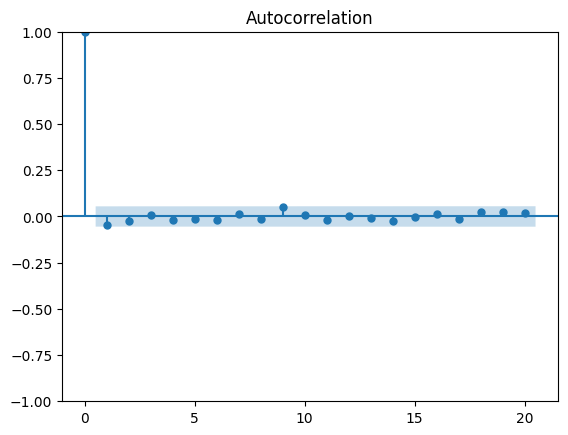

In [374]:

# Calculate ACF values with confidence intervals
acf_values, confint = acf(df['Close_diff'].dropna(), nlags=20, alpha=0.05)

# Compute upper and lower confidence intervals
lower_bound, upper_bound = confint[:, 0], confint[:, 1]

# Find significant lags based on confidence intervals
significant_lags = [lag for lag, value in enumerate(acf_values) if lag > 0 and (value < lower_bound[lag] or value > upper_bound[lag])]

print(f"Significant lags for MA component (q) in ARIMAX: {significant_lags}")

# Plot ACF for visualization
plot_acf(df['Close_diff'].dropna(), lags=20, alpha=0.05)
plt.show()

Significant lags for AR component (p) in ARIMAX: []


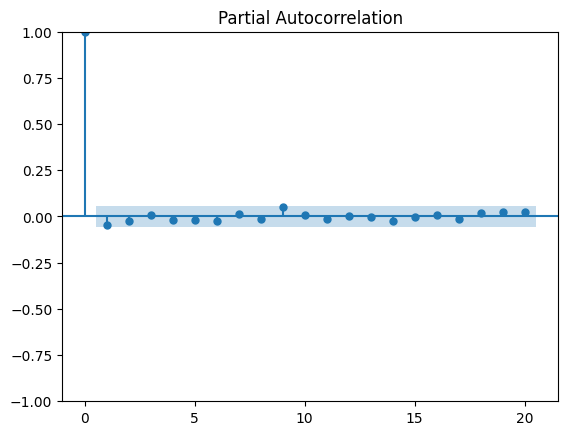

In [375]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

# Calculate PACF values with confidence intervals
pacf_values, confint = pacf(df['Close_diff'].dropna(), nlags=20, alpha=0.05, method="ywm")

# Compute upper and lower confidence intervals
lower_bound, upper_bound = confint[:, 0], confint[:, 1]

# Find significant lags based on confidence intervals
significant_lags = [lag for lag, value in enumerate(pacf_values) if lag > 0 and (value < lower_bound[lag] or value > upper_bound[lag])]

print(f"Significant lags for AR component (p) in ARIMAX: {significant_lags}")

# Plot PACF for visualization
plot_pacf(df['Close_diff'].dropna(), lags=20, alpha=0.05, method="ywm")
plt.show()

In [376]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close_diff'].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The series is stationary (p < 0.05). No need for differencing.")
else:
    print("The series is NOT stationary. Consider further differencing.")

ADF Statistic: -37.30339031166182
p-value: 0.0
The series is stationary (p < 0.05). No need for differencing.


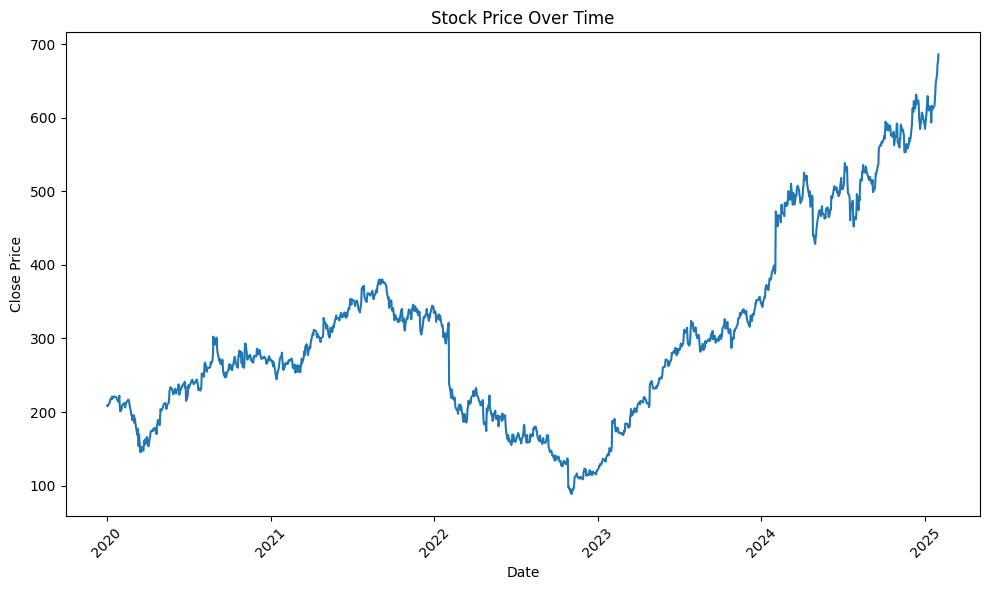

In [377]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'])  # Plot with 'Date' as the x-axis
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


#### Exogenous Variables for Meta:
For Meta’s stock price prediction,select the following exogenous variables:

**Interest rates:** Represents broader economic conditions that can influence the advertising budgets of businesses.

**S&P 500:** Captures the overall market sentiment and Meta’s relative performance.

**Advertising spending:** Directly impacts Meta’s revenue, especially from advertising.

**GDP Growth:** Reflects the economic environment that could affect Meta’s user base and ad revenue.

**User growth metrics:** Influences future revenue, as more users mean higher potential ad revenue.

In [378]:
df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Close_diff'], dtype='object')

In [379]:
pip install yfinance pandas_datareader requests

In [380]:
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import numpy as np

# Define the time period for the data
start_date = '2020-01-01'
end_date = '2025-03-31'

# 1. **S&P 500** Data
sp500 = yf.download('^GSPC', start=start_date, end=end_date)
sp500 = sp500[['Close']].rename(columns={'Close': 'SP500'})
sp500 = sp500.resample('D').ffill()  # Resample to daily frequency and forward fill

# 2. **Interest Rate** Data (US Federal Reserve Federal Funds Rate)
interest_rate = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)
interest_rate = interest_rate.rename(columns={'FEDFUNDS': 'Interest_Rate'})
interest_rate = interest_rate.resample('D').ffill()  # Resample to daily frequency and forward fill

# 3. **Advertising Spending** Data (Assume we are using a hypothetical dataset or API)
# For demonstration, we'll generate random data (you should replace it with actual data).
dates = pd.date_range(start=start_date, end=end_date, freq='D')
advertising_spending = pd.DataFrame({
    'Advertising_Spending': np.random.uniform(1000, 5000, size=len(dates))
}, index=dates)

# 4. **GDP Growth** Data (US GDP growth rate from FRED)
gdp_growth = web.DataReader('A191RL1Q225SBEA', 'fred', start_date, end_date)  # US GDP growth rate
gdp_growth = gdp_growth.rename(columns={'A191RL1Q225SBEA': 'GDP_Growth'})
gdp_growth = gdp_growth.resample('D').ffill()  # Resample to daily frequency and forward fill

# 5. **User Growth** Data (Assume we are using Meta's (Facebook) growth data)
# For demonstration, we’ll generate random user growth data (replace with actual data).
user_growth = pd.DataFrame({
    'User_Growth': np.random.uniform(1_000_000, 3_000_000, size=len(dates))
}, index=dates)

# Merge all external data sources into a single DataFrame
external_data = sp500.join([interest_rate, advertising_spending, gdp_growth, user_growth], how='left')

# Verify the data
print(external_data.head())

# Save the merged data to a CSV (optional)
external_data.to_csv('external_data.csv')

[*********************100%***********************]  1 of 1 completed


            (SP500, ^GSPC)  Interest_Rate  Advertising_Spending  GDP_Growth  \
Date                                                                          
2020-01-02     3257.850098           1.55           4802.857226        -5.5   
2020-01-03     3234.850098           1.55           3927.975767        -5.5   
2020-01-04     3234.850098           1.55           3394.633937        -5.5   
2020-01-05     3234.850098           1.55           1624.074562        -5.5   
2020-01-06     3246.280029           1.55           1623.978081        -5.5   

             User_Growth  
Date                      
2020-01-02  1.783051e+06  
2020-01-03  1.825244e+06  
2020-01-04  2.391236e+06  
2020-01-05  1.006437e+06  
2020-01-06  2.239179e+06  


In [381]:
# Reset the index on external_data
external_data = external_data.reset_index()

# Ensure the 'Date' column is of datetime type
external_data['Date'] = pd.to_datetime(external_data['Date'])

# Merge the DataFrames using the 'Date' column
merged_df = pd.merge(df, external_data, on='Date', how='left')

In [382]:
merged_df.head()

,Date,Close,High,Low,Open,Volume,Close_diff,"(SP500, ^GSPC)",Interest_Rate,Advertising_Spending,GDP_Growth,User_Growth
0,2020-01-02,208.795929,208.805877,205.302400,205.780144,12077100,NaN,3257.850098,1.55,4802.857226,-5.5,1.783051e+06
1,2020-01-03,207.691147,209.413027,205.979214,206.238004,11188400,-1.104782,3234.850098,1.55,3927.975767,-5.5,1.825244e+06
2,2020-01-06,211.602707,211.781855,205.551226,205.730374,17058900,3.911560,3246.280029,1.55,1623.978081,-5.5,2.239179e+06
3,2020-01-07,212.060562,213.573436,210.756710,211.821698,14912400,0.457855,3237.179932,1.55,1232.334449,-5.5,1.710986e+06
4,2020-01-08,214.210419,215.225638,211.612661,212.000831,13475000,2.149857,3253.050049,1.55,4464.704583,-5.5,2.588395e+06


In [383]:
merged_df.rename(columns={('SP500', '^GSPC'): 'SP500_GSPC'}, inplace=True)

In [384]:
merged_df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Close_diff',
       'SP500_GSPC', 'Interest_Rate', 'Advertising_Spending', 'GDP_Growth',
       'User_Growth'],
      dtype='object')

In [385]:
y = merged_df['Close']  # The stock price column
X = merged_df[['High', 'Low', 'Open', 'Volume','Interest_Rate', 'SP500_GSPC', 'Advertising_Spending', 'GDP_Growth', 'User_Growth']]  # Exogenous variables

In [386]:
# Check for missing or infinite values in X
print(X.isnull().sum())  # Check for NaNs in each column
print((X == float('inf')).sum())  # Check for infinite values in each column

High                     0
Low                      0
Open                     0
Volume                   0
Interest_Rate            0
SP500_GSPC               0
Advertising_Spending     0
GDP_Growth              82
User_Growth              0
dtype: int64
High                    0
Low                     0
Open                    0
Volume                  0
Interest_Rate           0
SP500_GSPC              0
Advertising_Spending    0
GDP_Growth              0
User_Growth             0
dtype: int64


In [387]:
# Remove rows with NaN or Inf in any of the exogenous variables
X = X.replace([float('inf'), -float('inf')], float('nan'))  # Replace Inf with NaN
X = X.dropna()  # Drop rows with NaN values
y = y[X.index]  # Ensure y matches the remaining rows in X

In [388]:
# Fill NaN values with the mean of each column
X = X.fillna(X.mean())

In [389]:
print(X.isnull().sum())  # Check if there are any NaN values
print((X == float('inf')).sum())  # Check for Inf values

High                    0
Low                     0
Open                    0
Volume                  0
Interest_Rate           0
SP500_GSPC              0
Advertising_Spending    0
GDP_Growth              0
User_Growth             0
dtype: int64
High                    0
Low                     0
Open                    0
Volume                  0
Interest_Rate           0
SP500_GSPC              0
Advertising_Spending    0
GDP_Growth              0
User_Growth             0
dtype: int64


In [390]:
merged_df.dropna(inplace=True)

In [391]:
merged_df.head()

,Date,Close,High,Low,Open,Volume,Close_diff,SP500_GSPC,Interest_Rate,Advertising_Spending,GDP_Growth,User_Growth
1,2020-01-03,207.691147,209.413027,205.979214,206.238004,11188400,-1.104782,3234.850098,1.55,3927.975767,-5.5,1.825244e+06
2,2020-01-06,211.602707,211.781855,205.551226,205.730374,17058900,3.911560,3246.280029,1.55,1623.978081,-5.5,2.239179e+06
3,2020-01-07,212.060562,213.573436,210.756710,211.821698,14912400,0.457855,3237.179932,1.55,1232.334449,-5.5,1.710986e+06
4,2020-01-08,214.210419,215.225638,211.612661,212.000831,13475000,2.149857,3253.050049,1.55,4464.704583,-5.5,2.588395e+06
5,2020-01-09,217.275986,217.355612,215.265457,216.519541,12642800,3.065567,3274.699951,1.55,3404.460047,-5.5,1.185981e+06


In [392]:
merged_df.isnull().sum()

,0
Date,0
Close,0
High,0
Low,0
Open,0
Volume,0
Close_diff,0
SP500_GSPC,0
Interest_Rate,0
Advertising_Spending,0


In [393]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas_datareader.data as web

# After merging, handle missing values in the merged DataFrame
# Use forward fill to propagate the last valid observation forward
merged_df = merged_df.fillna(method='ffill')

# If forward fill doesn't work for certain columns or you have other specific needs:

# Impute missing values with the mean of each column (alternative to forward fill)
for col in ['Interest_Rate', 'SP500_GSPC', 'Advertising_Spending', 'GDP_Growth', 'User_Growth']:
    merged_df[col] = merged_df[col].fillna(merged_df[col].mean())


# Now, reassign your X and y variables
y = merged_df['Close']
X = merged_df[['High', 'Low', 'Open', 'Volume','Interest_Rate', 'SP500_GSPC', 'Advertising_Spending', 'GDP_Growth', 'User_Growth']]

# Verify no more nulls
print(X.isnull().sum())

High                    0
Low                     0
Open                    0
Volume                  0
Interest_Rate           0
SP500_GSPC              0
Advertising_Spending    0
GDP_Growth              0
User_Growth             0
dtype: int64


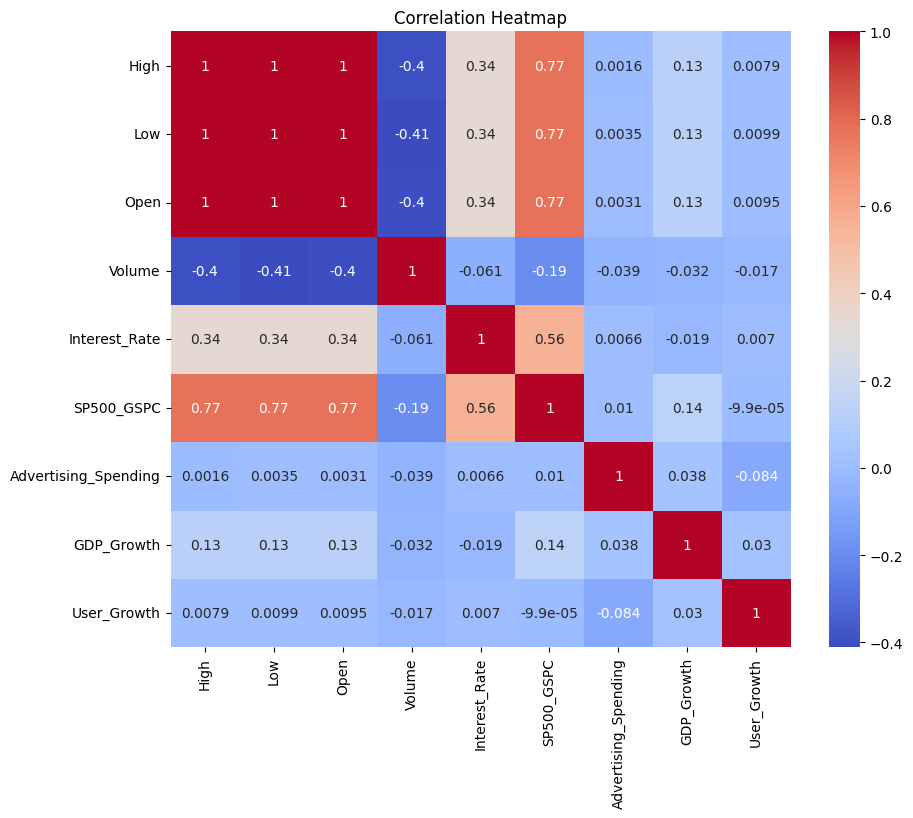

In [394]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [395]:
# Define the train-test split ratio
train_size = int(len(merged_df) * 0.8)  # 80% train, 20% test

# Split the dataset
train_df = merged_df.iloc[:train_size]  # First 80% for training
test_df = merged_df.iloc[train_size:]   # Last 20% for testing

In [396]:
# Define target variable (stock price)
y_train = train_df['Close']
y_test = test_df['Close']

# Define exogenous variables
X_train = train_df[['Interest_Rate', 'SP500_GSPC', 'Advertising_Spending', 'GDP_Growth', 'User_Growth', 'High', 'Low', 'Open', 'Volume']]
X_test = test_df[['Interest_Rate', 'SP500_GSPC', 'Advertising_Spending', 'GDP_Growth', 'User_Growth', 'High', 'Low', 'Open', 'Volume']]

In [397]:
# Replace infinite values with NaN
X_train = X_train.replace([float('inf'), -float('inf')], float('nan'))
X_test = X_test.replace([float('inf'), -float('inf')], float('nan'))

# Fill missing values with the mean of each column
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [398]:
# Fit ARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

p=0
q=0
d=0

model = ARIMA(y_train, exog=X_train, order=(p, d, q))
results = model.fit()

# Print the summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  955
Model:                          ARIMA   Log Likelihood               -4860.874
Date:                Fri, 11 Apr 2025   AIC                           9743.748
Time:                        15:24:16   BIC                           9797.226
Sample:                             0   HQIC                          9764.119
                                - 955                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5284      0.186      2.848      0.004       0.165       0.892
Interest_Rate           -0.0059     37.687     -0.000      1.000     -73.872      73.860
SP500_GSPC  

In [399]:
y_train_pred = results.predict(start=0, end=len(y_train) - 1, exog=X_train)

train_predictions = train_df[['Date', 'Close']].copy()
train_predictions['Predicted_Close'] = y_train_pred.values

print("Training Predictions:")
print(train_predictions.head())

Training Predictions:
        Date       Close  Predicted_Close
1 2020-01-03  207.691147       208.655267
2 2020-01-06  211.602707       210.681633
3 2020-01-07  212.060562       212.644059
4 2020-01-08  214.210419       214.363337
5 2020-01-09  217.275986       216.257176


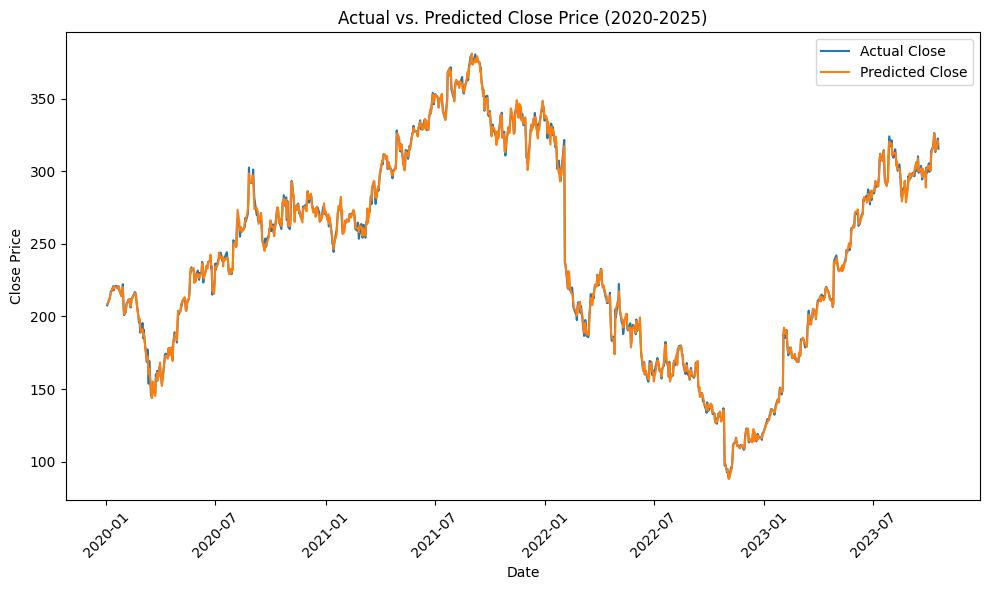

In [400]:
# Plot the actual and predicted values from 2020 to 2025
plt.figure(figsize=(10, 6))

# Filter the data for the specified period
plot_df = train_predictions[(train_predictions['Date'] >= '2020-01-01') & (train_predictions['Date'] <= '2025-03-31')]

plt.plot(plot_df['Date'], plot_df['Close'], label='Actual Close')
plt.plot(plot_df['Date'], plot_df['Predicted_Close'], label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price (2020-2025)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [401]:
y_test_pred = results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

test_predictions = test_df[['Date', 'Close']].copy()
test_predictions['Predicted_Close'] = y_test_pred.values

print("Test Predictions:")
print(test_predictions.head())

Test Predictions:
          Date       Close  Predicted_Close
956 2023-10-19  311.342621       313.506396
957 2023-10-20  307.202118       307.229416
958 2023-10-23  312.537018       312.591535
959 2023-10-24  311.083832       311.691297
960 2023-10-25  298.124969       300.175999


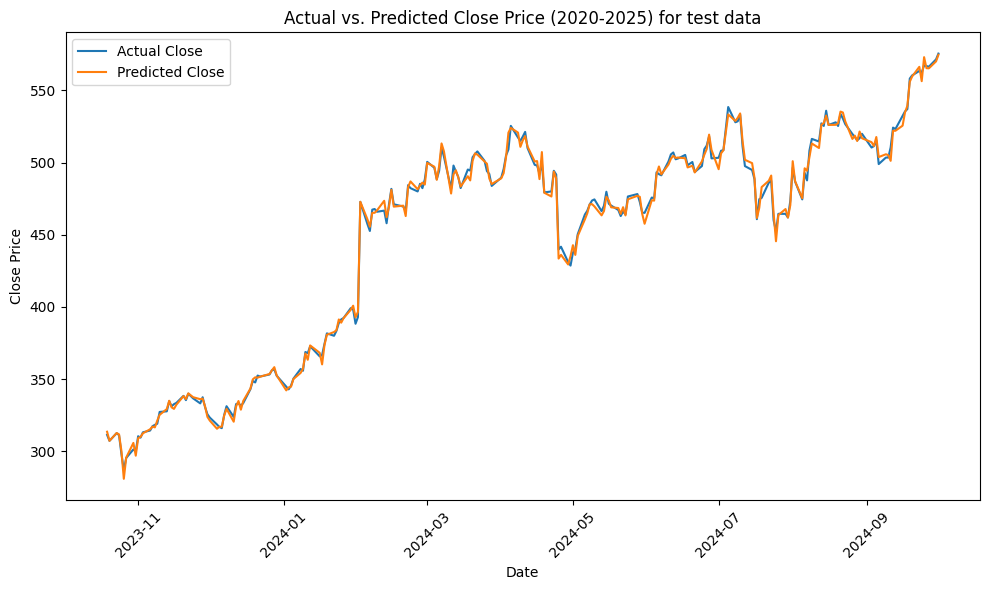

In [402]:
import matplotlib.dates as mdates
# Plot the actual and predicted values from 2020 to 2025
plt.figure(figsize=(10, 6))

# Filter the data for the specified period
plot_df = test_predictions[(test_predictions['Date'] >= '2020-01-01') & (test_predictions['Date'] <= '2025-03-31')]

plt.plot(plot_df['Date'], plot_df['Close'], label='Actual Close')
plt.plot(plot_df['Date'], plot_df['Predicted_Close'], label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price (2020-2025) for test data')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

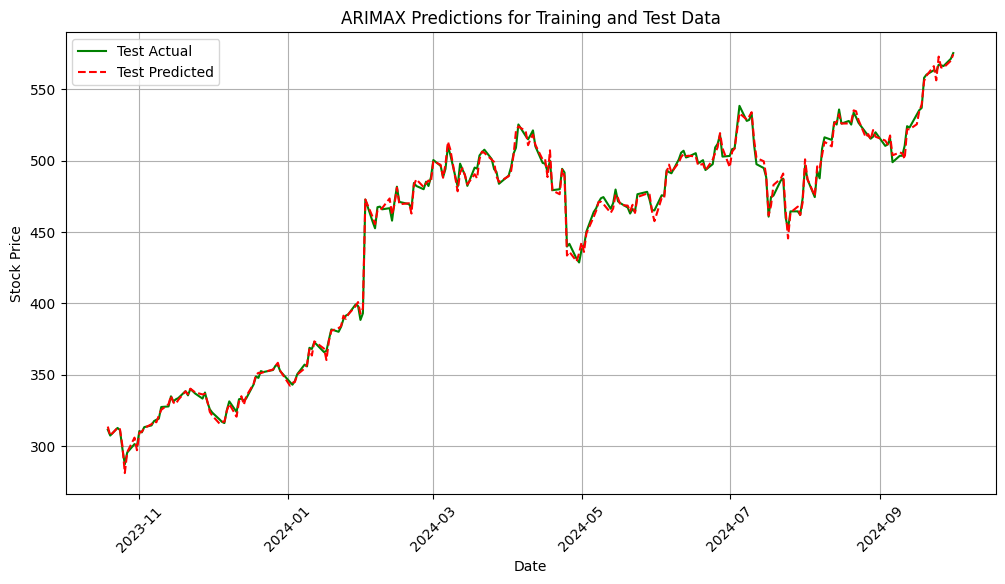

In [403]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot test actual vs predicted
plt.plot(test_predictions['Date'], test_predictions['Close'], label="Test Actual", color='green')
plt.plot(test_predictions['Date'], test_predictions['Predicted_Close'], label="Test Predicted", color='red', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("ARIMAX Predictions for Training and Test Data")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [404]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train Metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Test Metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Create a DataFrame to display metrics in a table format
metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Train': [mae_train, mse_train, rmse_train, r2_train],
    'Test': [mae_test, mse_test, rmse_test, r2_test]
})

# Print the metrics table
print(metrics)


  Metric     Train      Test
0    MAE  1.604229  2.428877
1    MSE  4.389454  9.753863
2   RMSE  2.095102  3.123117
3     R²  0.999104  0.998336


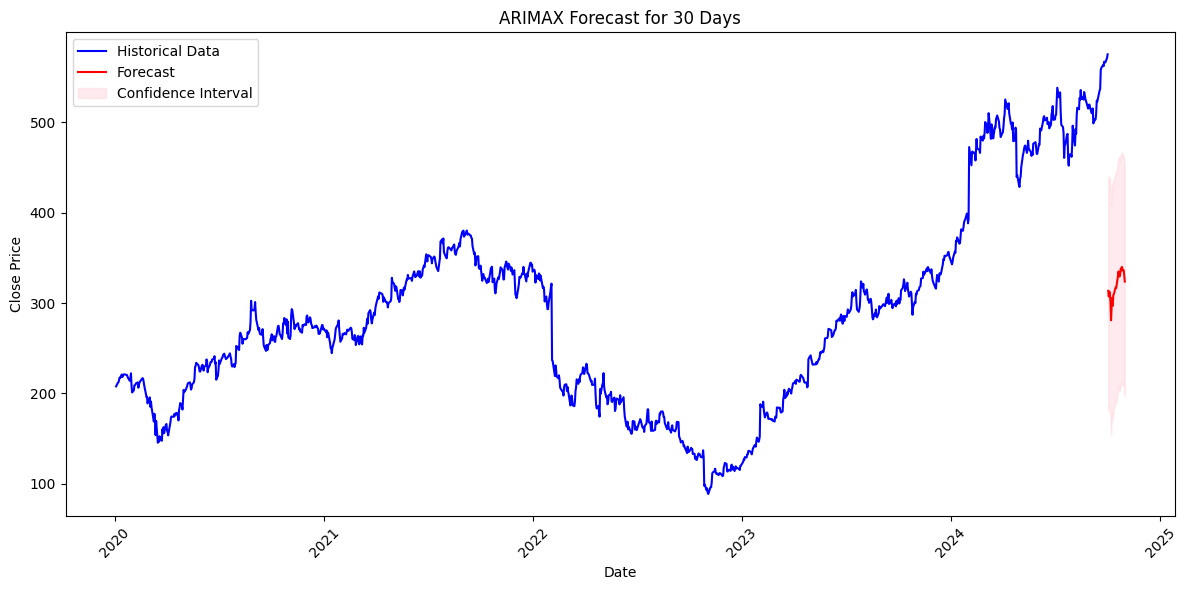

In [407]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Forecast future values
steps_ahead = 30  # Number of steps to forecast into the future
forecast = results.get_forecast(steps=steps_ahead, exog=X_test.iloc[:steps_ahead]) # Use .iloc[:steps_ahead] to slice X_test


# Get the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create a date range for the forecast
future_dates = pd.date_range(start=merged_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=steps_ahead)


# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['Close'], label='Historical Data', color='blue')
plt.plot(future_dates, forecast_mean, label='Forecast', color='red')

plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'ARIMAX Forecast for {steps_ahead} Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## SARIMAX MODEL


In [298]:
merged_df.corr()['Close']

,Close
Date,0.488390
Close,1.000000
High,0.999493
Low,0.999526
Open,0.998846
Volume,-0.404980
Close_diff,0.074786
SP500_GSPC,0.772724
Interest_Rate,0.340425
Advertising_Spending,-0.019337


In [299]:
merged_df.head()

,Date,Close,High,Low,Open,Volume,Close_diff,SP500_GSPC,Interest_Rate,Advertising_Spending,GDP_Growth,User_Growth
1,2020-01-03,207.691147,209.413027,205.979214,206.238004,11188400,-1.104782,3234.850098,1.55,1599.593212,-5.5,2.232354e+06
2,2020-01-06,211.602707,211.781855,205.551226,205.730374,17058900,3.911560,3246.280029,1.55,4521.413352,-5.5,2.889083e+06
3,2020-01-07,212.060562,213.573436,210.756710,211.821698,14912400,0.457855,3237.179932,1.55,4614.772186,-5.5,2.257918e+06
4,2020-01-08,214.210419,215.225638,211.612661,212.000831,13475000,2.149857,3253.050049,1.55,3198.857907,-5.5,1.871182e+06
5,2020-01-09,217.275986,217.355612,215.265457,216.519541,12642800,3.065567,3274.699951,1.55,2208.196133,-5.5,2.298563e+06


In [300]:
y = merged_df['Close']

# Update the features based on correlation values
X = merged_df[['High', 'Low', 'Open', 'SP500_GSPC']]

In [301]:
split_index = int(len(merged_df) * 0.8)
y_train, y_test = y[:split_index], y[split_index:]
X_train, X_test = X[:split_index], X[split_index:]

In [302]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y_train, exog=X_train, order=(0, 0, 0))
results = model.fit(disp=False)
# Print the summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  955
Model:                        SARIMAX   Log Likelihood               -2066.621
Date:                Fri, 11 Apr 2025   AIC                           4143.241
Time:                        13:11:34   BIC                           4167.550
Sample:                             0   HQIC                          4152.501
                                - 955                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High           0.8222      0.020     40.820      0.000       0.783       0.862
Low            0.7906      0.019     42.142      0.000       0.754       0.827
Open          -0.6106      0.023    -26.181      0.0

In [303]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# -------------------------
# Predictions
# -------------------------
# Predict on training set
y_train_pred = results.predict(start=0, end=len(y_train)-1, exog=X_train)

# Predict on test set
y_test_pred = results.predict(start=len(y_train), end=len(y)-1, exog=X_test)

# -------------------------
# Train Metrics
# -------------------------
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# -------------------------
# Test Metrics
# -------------------------
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# -------------------------
# Create DataFrame for Summary Table
# -------------------------
metrics = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Train Set': [mae_train, mse_train, rmse_train, r2_train],
    'Test Set': [mae_test, mse_test, rmse_test, r2_test]
}

summary_df = pd.DataFrame(metrics)

# -------------------------
# Print the Summary Table
# -------------------------
print("✅ Model Evaluation Summary")
print(summary_df)

✅ Model Evaluation Summary
  Metric  Train Set  Test Set
0    MAE   1.616929  2.409005
1    MSE   4.437591  9.699947
2   RMSE   2.106559  3.114474
3     R²   0.999094  0.998345


In [304]:
(y_test_pred.iloc[:1])

,predicted_mean
955,313.51215


In [305]:
list(y_test.iloc[:1])[0]

311.3426208496094

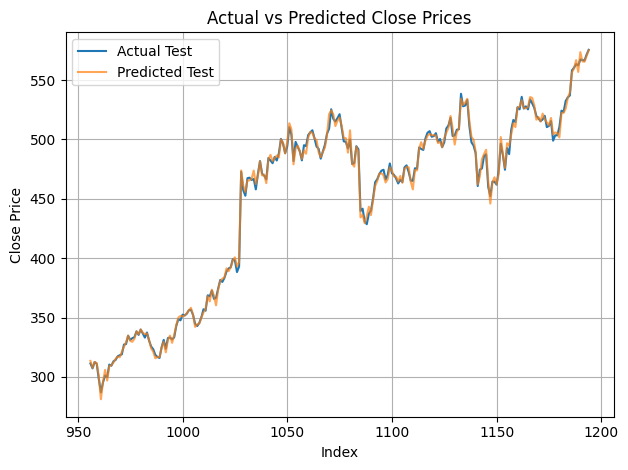

In [306]:
import matplotlib.pyplot as plt


# Plot test predictions
plt.plot(y_test.index, y_test, label='Actual Test')
plt.plot(y_test.index, y_test_pred, label='Predicted Test', alpha=0.7)

plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [307]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Define ranges for p, d, q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Store results
results_list = []

warnings.filterwarnings("ignore")  # avoid printing warnings

for param in pdq:
    try:
        model = SARIMAX(y_train, exog=X_train, order=param, enforce_stationarity=False, enforce_invertibility=False)
        result = model.fit(disp=False)
        results_list.append({
            'order': param,
            'AIC': result.aic,
            'BIC': result.bic
        })
    except:
        continue

# Convert results to DataFrame
import pandas as pd
tuning_results = pd.DataFrame(results_list)
best_model = tuning_results.sort_values('AIC').iloc[0]
print("Best Parameters based on AIC:")
print(best_model)

Best Parameters based on AIC:
order      (0, 0, 2)
AIC      4130.260756
BIC      4164.270711
Name: 2, dtype: object


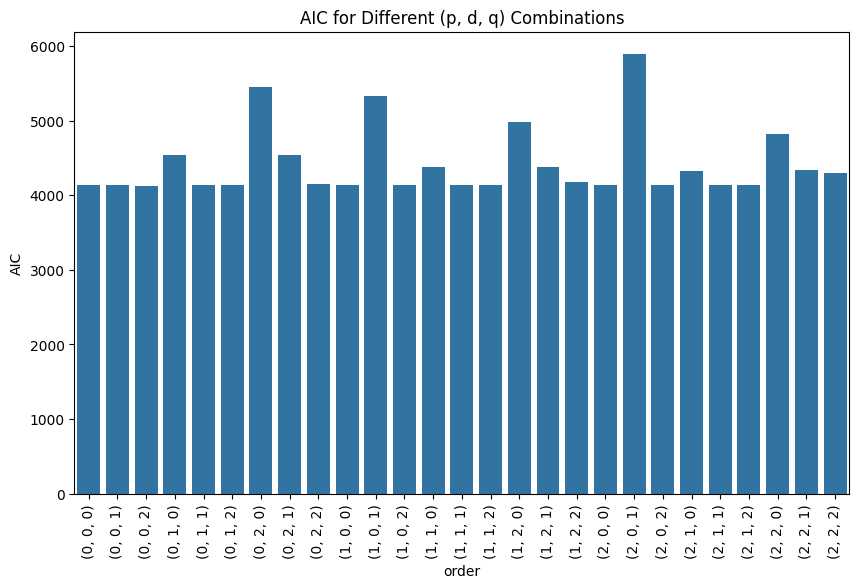

In [308]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x=tuning_results['order'].astype(str), y=tuning_results['AIC'])
plt.xticks(rotation=90)
plt.title('AIC for Different (p, d, q) Combinations')
plt.show()

In [309]:
best_model['order']

(0, 0, 2)

In [310]:
best_p, best_d, best_q = best_model['order']
model = SARIMAX(y_train, exog=X_train, order=(best_p, best_d, best_q))
results = model.fit()

# Print the summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  955
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -2063.377
Date:                Fri, 11 Apr 2025   AIC                           4140.754
Time:                        13:12:28   BIC                           4174.786
Sample:                             0   HQIC                          4153.718
                                - 955                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High           0.7857      0.020     39.546      0.000       0.747       0.825
Low            0.8175      0.019     43.514      0.000       0.781       0.854
Open          -0.6018      0.023    -25.986      0.0

✅ Model Evaluation Summary
  Metric  Train Set  Test Set
0    MAE   1.611231  2.409819
1    MSE   4.407457  9.627018
2   RMSE   2.099394  3.102744
3     R²   0.999101  0.998358


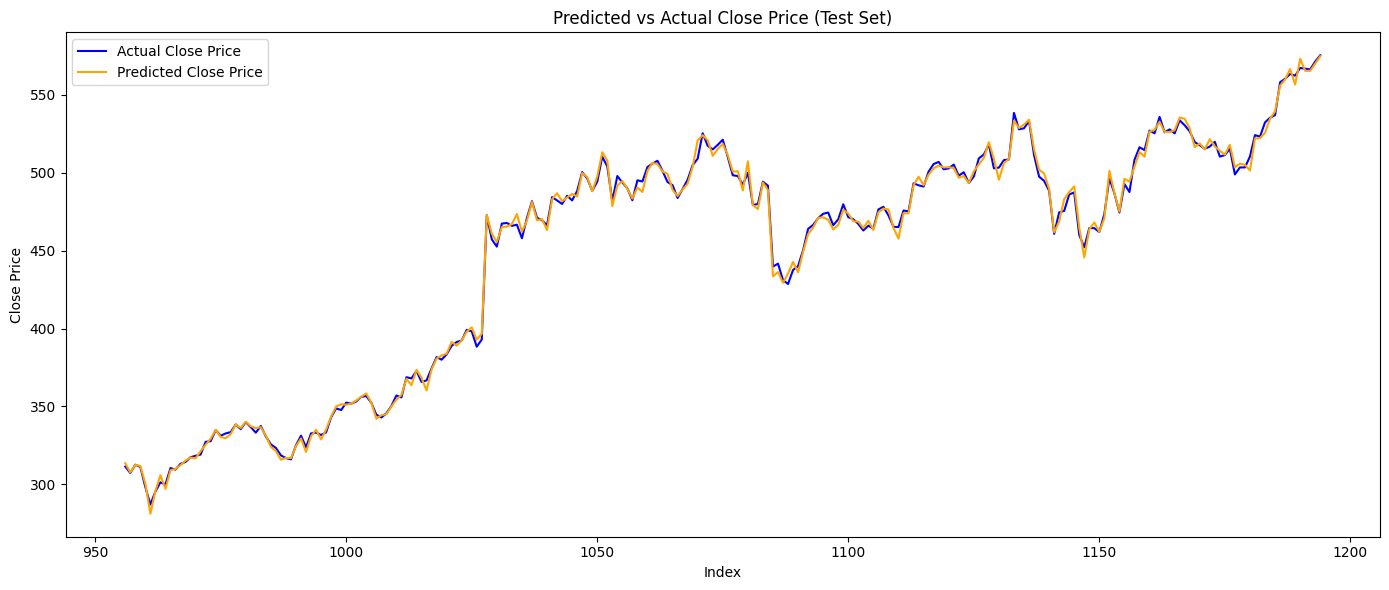

In [311]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# -------------------------
# Predictions
# -------------------------
# Predict on training set
y_train_pred = results.predict(start=0, end=len(y_train)-1, exog=X_train)

# Predict on test set
y_test_pred = results.predict(start=len(y_train), end=len(y)-1, exog=X_test)

# -------------------------
# Train Metrics
# -------------------------
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# -------------------------
# Test Metrics
# -------------------------
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# -------------------------
# Create DataFrame for Summary Table
# -------------------------
metrics = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Train Set': [mae_train, mse_train, rmse_train, r2_train],
    'Test Set': [mae_test, mse_test, rmse_test, r2_test]
}

summary_df = pd.DataFrame(metrics)

# -------------------------
# Print the Summary Table
# -------------------------
print("✅ Model Evaluation Summary")
print(summary_df)


plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label='Actual Close Price', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted Close Price', color='orange')
plt.title("Predicted vs Actual Close Price (Test Set)")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

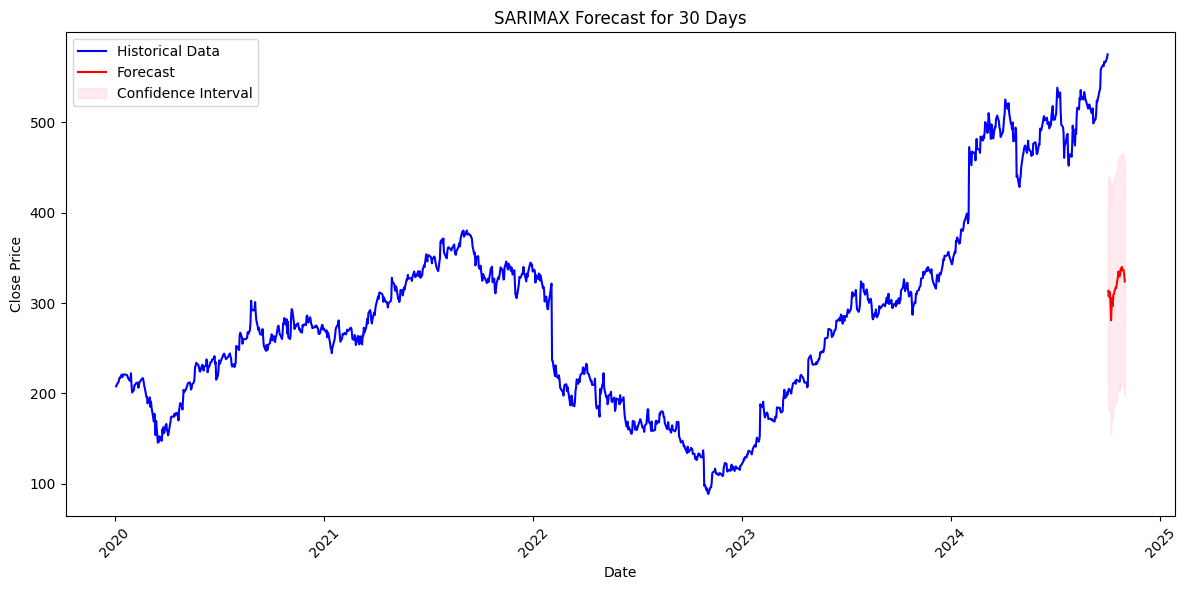

In [408]:
# Forecast future values
steps_ahead = 30  # Number of steps to forecast into the future
forecast = results.get_forecast(steps=steps_ahead, exog=X_test.iloc[:steps_ahead]) # Use .iloc[:steps_ahead] to slice X_test


# Get the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create a date range for the forecast
future_dates = pd.date_range(start=merged_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=steps_ahead)


# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['Close'], label='Historical Data', color='blue')
plt.plot(future_dates, forecast_mean, label='Forecast', color='red')

plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'SARIMAX Forecast for {steps_ahead} Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## LSTM

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#Install keras-tuner using !pip install keras-tuner
!pip install keras-tuner # Install keras-tuner
from kerastuner.tuners import BayesianOptimization #Now you can import BayesianOptimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [319]:
pip install yfinance

In [320]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=993f07b37eb0a3cdc657e4fd2471da7977781a7701d4b44fef86a5135035a5a0
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [321]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

meta = pd.read_csv("META.csv")
meta = meta[2:]
meta = meta.reset_index()
meta = meta.drop(columns=["index"])
# Rename 'Date' column in meta to 'Price', the original column name in the CSV.
meta = meta.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
meta.head()

meta[columns_to_convert] = meta[columns_to_convert].astype(float)
meta['Date'] = pd.to_datetime(meta['Date']) # Convert the 'Date' column to datetime
meta['Volume'] = meta['Volume'].astype(int)
# meta.head() # Uncomment to check the DataFrame structure

df = meta
# Now you can filter using the 'Date' column:
df = df[df['Date']>=pd.Timestamp(2020,1,1)].reset_index().drop(columns=["index"]) # Use pd.Timestamp
df = df[df['Date']<pd.Timestamp(2025,1,31)] # Use pd.Timestamp

In [322]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,208.795929,208.805877,205.302400,205.780144,12077100
1,2020-01-03,207.691147,209.413027,205.979214,206.238004,11188400
2,2020-01-06,211.602707,211.781855,205.551226,205.730374,17058900
3,2020-01-07,212.060562,213.573436,210.756710,211.821698,14912400
4,2020-01-08,214.210419,215.225638,211.612661,212.000831,13475000


In [323]:
# drop the first row

df = df.iloc[1:]
df.tail()


,Date,Close,High,Low,Open,Volume
1272,2025-01-24,646.914429,651.420429,633.636264,635.834321,19065300
1273,2025-01-27,659.293457,663.279901,624.544343,626.053010,28399200
1274,2025-01-28,673.730591,681.973257,658.883754,665.407978,20950100
1275,2025-01-29,675.888672,680.444616,665.078282,674.400006,21377800
1276,2025-01-30,686.389343,710.158175,675.499008,696.200622,29322900


In [324]:
#  the missing values

print(df.isnull().sum())


Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [325]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Select features and target variable
features = ['High', 'Low', 'Open', 'Volume']
target = 'Close'

# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features + [target]]), columns=features + [target], index=df.index)

# Prepare sequences for LSTM
def create_sequences(data, feature_cols, target_col, time_steps=60):
    np.random.seed(42)
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[feature_cols].iloc[i:i+time_steps].values)
        y.append(data[target_col].iloc[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 60  # Use past 60 days for prediction
X, y = create_sequences(df_scaled, features, target, time_steps)

# Split into training and testing sets(80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)


In [326]:
!pip install keras-tuner

In [327]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch

# Define the model function for tuning
def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('units1', min_value=50, max_value=200, step=50), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])),
        LSTM(hp.Int('units2', min_value=50, max_value=200, step=50), return_sequences=False),
        Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])),
        Dense(25, activation=hp.Choice('activation', ['relu', 'tanh'])),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of different models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='lstm_tuner',
    project_name='stock_prediction'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
best_model.evaluate(X_test, y_test)


Trial 10 Complete [00h 03m 04s]
val_loss: 0.0011159415589645505

Best val_loss So Far: 0.0007856235606595874
Total elapsed time: 00h 28m 20s
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - loss: 0.0250 - val_loss: 0.0065
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 322ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - loss: 8.8447e-04 - val_loss: 0.0052
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - loss: 8.7519e-04 - val_loss: 0.0020
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - loss: 8.1322e-04 - val_loss: 0.0013
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - loss: 8.8465e-04 - val_loss: 0.0026
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - loss: 7.5085e-04 - val_loss: 0.0017
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - lo

0.0013994697947055101

In [328]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score

In [330]:
import matplotlib.dates as mdates

In [331]:
import pandas as pd

# Assuming your date column is named 'Date'
df['Date'] = pd.to_datetime(df['Date'])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step

📊 Evaluation Metrics for Best Model:

      Metric     Train      Test
0        MAE    8.5647   17.9772
1        MSE  135.2868  500.2827
2       RMSE   11.6313   22.3670
3  R-squared    0.9754    0.8322


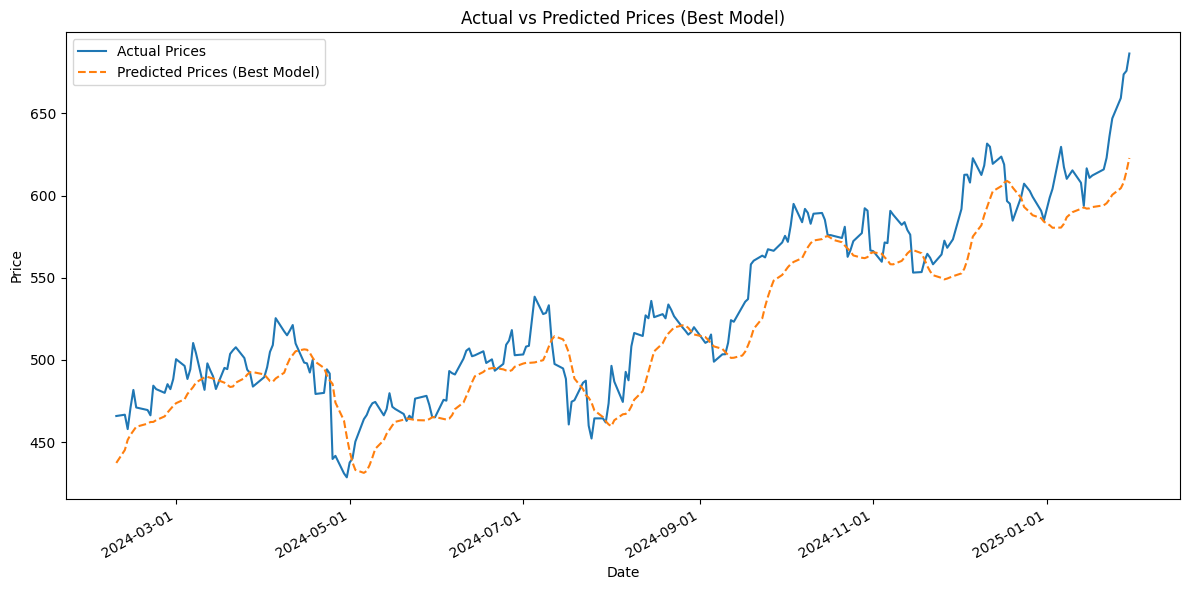

In [332]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions with the best model
best_predictions = best_model.predict(X_test)

# Inverse transform the predictions to the original scale
best_predictions_inv = scaler.inverse_transform(
    np.concatenate((X_test[:, -1, :], best_predictions.reshape(-1, 1)), axis=1)
)[:, -1]

# Evaluate the best model on the training data
best_train_predictions = best_model.predict(X_train)
best_train_predictions_inv = scaler.inverse_transform(
    np.concatenate((X_train[:, -1, :], best_train_predictions.reshape(-1, 1)), axis=1)
)[:, -1]

# Inverse y_train and y_test already available: y_train_inv, y_test_inv

# Error metrics - Training
train_mae = mean_absolute_error(y_train_inv, best_train_predictions_inv)
train_mse = mean_squared_error(y_train_inv, best_train_predictions_inv)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inv, best_train_predictions_inv)

# Error metrics - Testing
test_mae = mean_absolute_error(y_test_inv, best_predictions_inv)
test_mse = mean_squared_error(y_test_inv, best_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_inv, best_predictions_inv)

# Combine all metrics in a table
best_evaluation_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R-squared'],
    'Train': [train_mae, train_mse, train_rmse, train_r2],
    'Test': [test_mae, test_mse, test_rmse, test_r2]
})

print("\n📊 Evaluation Metrics for Best Model:\n")
print(best_evaluation_metrics.round(4))

# 📈 Plot for the best model
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test_inv, label="Actual Prices")
plt.plot(df['Date'].iloc[-len(y_test):], best_predictions_inv, label="Predicted Prices (Best Model)", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.title("Actual vs Predicted Prices (Best Model)")
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

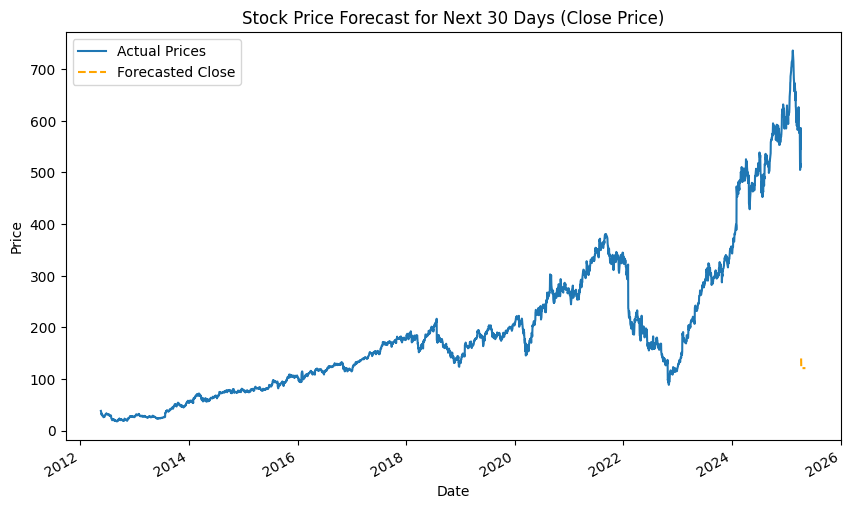

In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Select features and target variable
features = ['High','Low', 'Open', 'Volume']
target = 'Close'

# Scale the dataset using the same scaler used during training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(meta[features])

# Get the last data point (from 2024-12-31) to start the forecasting
last_data_point = scaled_data[-1].reshape(1, 1, len(features))

# Initialize a list to store the forecasted prices
forecasted_prices = []

# Forecast for the next 30 days
for i in range(30):
    # Predict the next day's Close price using the trained model
    predicted_close = best_model.predict(last_data_point, verbose=0)[0][0]

    # Append the predicted price to the forecasted prices list
    forecasted_prices.append(predicted_close)

    # Update the last data point for the next prediction
    # Shift the sequence and append the predicted Close value to the features
    last_data_point = np.append(last_data_point[:, 1:, :], [[np.append(scaled_data[-1, 1:], predicted_close)]], axis=1)

# Construct the array for inverse transformation with the forecasted values in the first column
forecast_array = np.zeros((30, len(features)))
forecast_array[:, 0] = forecasted_prices  # Place the forecasted Close in the first column

# Rescale the forecasted prices back to the original scale (reverse transformation)
forecast_rescaled = scaler.inverse_transform(forecast_array)[:, 0]  # Extract the rescaled Close prices

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start=meta['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df = pd.DataFrame(forecast_rescaled, columns=['Predicted Close'], index=forecast_dates)

# Plot the actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(meta['Date'], meta['Close'], label='Actual Prices')
plt.plot(forecast_df.index, forecast_df['Predicted Close'], label='Forecasted Close', linestyle='--', color='orange')
plt.legend()
plt.title("Stock Price Forecast for Next 30 Days (Close Price)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.gcf().autofmt_xdate()
plt.show()


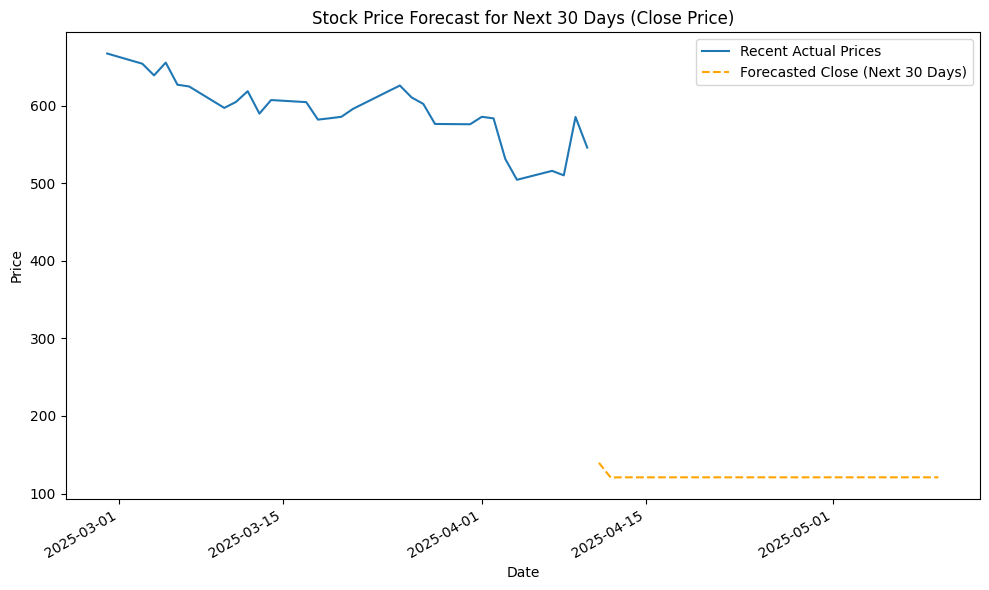

In [334]:
# Number of past actual days to show before the forecast (optional)
context_days = 30

# Get the last `context_days` of actual data
recent_actual_dates = meta['Date'].iloc[-context_days:]
recent_actual_close = meta['Close'].iloc[-context_days:]

# Plot recent actual data and forecast
plt.figure(figsize=(10, 6))
plt.plot(recent_actual_dates, recent_actual_close, label='Recent Actual Prices')
plt.plot(forecast_df.index, forecast_df['Predicted Close'], label='Forecasted Close (Next 30 Days)', linestyle='--', color='orange')
plt.legend()
plt.title("Stock Price Forecast for Next 30 Days (Close Price)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


In [335]:
# Model builder for KerasTuner
from tensorflow.keras.optimizers import Adam, RMSprop

In [336]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        return_sequences = i < hp.get('num_layers') - 1
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                       return_sequences=return_sequences,
                       input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr) if optimizer=='adam' else RMSprop(learning_rate=lr))
    return model

In [337]:
# Tuner setup
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials= 8,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='stock_lstm')

In [338]:
# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5)

In [339]:
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stop, reduce_lr])

Trial 8 Complete [00h 00m 30s]
val_loss: 0.0007325178012251854

Best val_loss So Far: 0.0003201985382474959
Total elapsed time: 00h 03m 52s


In [340]:
# Get best model
best_model_2 = tuner.get_best_models(num_models=1)[0]

In [341]:
model = build_model(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters)
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,
          callbacks=[early_stop, reduce_lr])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0295 - val_loss: 0.0331 - learning_rate: 0.0022
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0042 - val_loss: 6.8378e-04 - learning_rate: 0.0022
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0019 - val_loss: 0.0035 - learning_rate: 0.0022
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0017 - val_loss: 0.0015 - learning_rate: 0.0022
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0018 - val_loss: 0.0103 - learning_rate: 0.0022
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0018 - val_loss: 0.0013 - learning_rate: 0.0011
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 9.3700e-04 - val_loss: 0.0015 - learning_rate: 0.0011


In [344]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Predict on training and testing sets
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Calculate metrics for training data
train_mae = mean_absolute_error(y_train, train_preds)
train_mse = mean_squared_error(y_train, train_preds)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_preds)

# Calculate metrics for testing data
test_mae = mean_absolute_error(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_preds)

# Create a DataFrame with both training and test metrics
evaluation_df = pd.DataFrame({
    'Metric': ['MAE','MSE','RMSE','R-squared'],
    'Training': [train_mae,train_mse, train_rmse, train_r2],
    'Testing': [test_mae, test_mse,test_rmse, test_r2]
})

# Round the values for better readability
evaluation_df = evaluation_df.round(4)

# Display the table
print("\n📊 Evaluation Metrics Summary:\n")
print(evaluation_df)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

📊 Evaluation Metrics Summary:

      Metric  Training  Testing
0        MAE    0.0234   0.0362
1        MSE    0.0008   0.0021
2       RMSE    0.0291   0.0454
3  R-squared    0.9448   0.7524


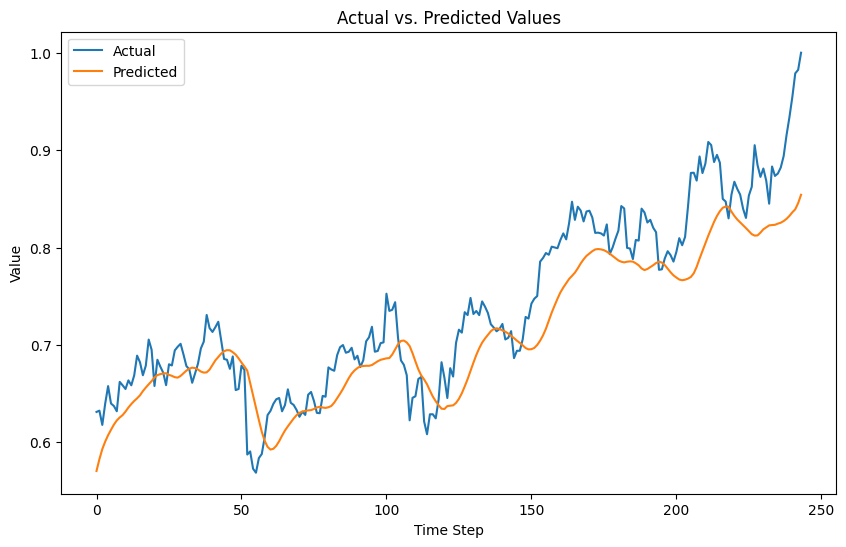

In [349]:
import matplotlib.pyplot as plt

# Assuming 'y_test' and 'test_preds' are available from your previous code
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_preds, label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()


## Prophet

In [409]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.5 MB/s eta 0:00:00


In [410]:

import pandas as pd
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt

# Prophet
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [411]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

meta = pd.read_csv("META.csv")
meta = meta[2:]
meta = meta.reset_index()
meta = meta.drop(columns=["index"])
# Rename 'Date' column in meta to 'Price', the original column name in the CSV.
meta = meta.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
meta.head()

meta[columns_to_convert] = meta[columns_to_convert].astype(float)
meta['Date'] = pd.to_datetime(meta['Date']) # Convert the 'Date' column to datetime
meta['Volume'] = meta['Volume'].astype(int)
# meta.head() # Uncomment to check the DataFrame structure

df = meta
# Now you can filter using the 'Date' column:
df = df[df['Date']>=pd.Timestamp(2020,1,1)].reset_index().drop(columns=["index"]) # Use pd.Timestamp
df = df[df['Date']<pd.Timestamp(2025,1,31)] # Use pd.Timestamp

In [412]:
train_df = df[['Date', 'Close', 'Volume']]
train_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [413]:
test_df = actual[['Date', 'Close', 'Volume']]
test_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [414]:
train_sub, val_sub= train_test_split(train_df, test_size=0.2, random_state=42, shuffle=False)


In [415]:
len(train_sub), len(val_sub), len(test_df)

(1021, 256, 501)

In [416]:
train_df

,ds,y,Volume
0,2020-01-02,208.795929,12077100
1,2020-01-03,207.691147,11188400
2,2020-01-06,211.602707,17058900
3,2020-01-07,212.060562,14912400
4,2020-01-08,214.210419,13475000
...,...,...,...
1272,2025-01-24,646.914429,19065300
1273,2025-01-27,659.293457,28399200
1274,2025-01-28,673.730591,20950100
1275,2025-01-29,675.888672,21377800


In [417]:
from prophet.diagnostics import cross_validation, performance_metrics


def objective(trial):
    # Hyperparameters to tune
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"])
    changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.01, 10.0, log=True)
    seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 0.01, 10.0, log=True)
    holidays_prior_scale = trial.suggest_float("holidays_prior_scale", 0.01, 10.0, log=True)

    # Build the Prophet model
    model = Prophet(
        seasonality_mode=seasonality_mode,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
    )

    # Add extra regressors
    model.add_regressor('Volume')
    # train_sub, valsub= train_test_split(train_df, test_size=0.2, random_state=42, shuffle=False)

    # Fit on the train_sub
    model.fit(train_df)

    df_cv = cross_validation(
        model=model,
        initial='730 days',   # e.g., use ~2 years of data before first cutoff
        horizon='90 days',    # e.g., 3-month forecast horizon
        period='90 days'      # new fold every 3 months
    )

    # Predict on val_sub
    df_metrics = performance_metrics(df_cv, rolling_window=1)
    rmse_cv = df_metrics['rmse'].values[0]  # We'll optimize for RMSE

    return rmse_cv

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)  # Increase n_trials for more thorough search


[I 2025-04-11 15:33:36,798] A new study created in memory with name: no-name-adf3caa2-70c4-44bb-8133-673c587b5594
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/oalcq5ou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/wa172xun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83752', 'data', 'file=/tmp/tmpb4s3ixsw/oalcq5ou.json', 'init=/tmp/tmpb4s3ixsw/wa172xun.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modeljs5smm1e/prophet_model-20250411153340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:33:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:33:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 12 forec

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/t0wj4tnj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/oli0wq6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99101', 'data', 'file=/tmp/tmpb4s3ixsw/t0wj4tnj.json', 'init=/tmp/tmpb4s3ixsw/oli0wq6_.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model9mfeyvxb/prophet_model-20250411153345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:33:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:33:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/4_n0lj5u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/mc7dezai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/413og9ap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/xy67ovh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10015', 'data', 'file=/tmp/tmpb4s3ixsw/413og9ap.json', 'init=/tmp/tmpb4s3ixsw/xy67ovh3.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelfpd8w37f/prophet_model-20250411153418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ewrnxjz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/1m1oy62w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/9l4nw49i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/5b9qcxyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80395', 'data', 'file=/tmp/tmpb4s3ixsw/9l4nw49i.json', 'init=/tmp/tmpb4s3ixsw/5b9qcxyd.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelnxh7r1cy/prophet_model-20250411153427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/k_xe4d_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ia_38m_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/3zxu7di1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/lfuhbkwg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27433', 'data', 'file=/tmp/tmpb4s3ixsw/3zxu7di1.json', 'init=/tmp/tmpb4s3ixsw/lfuhbkwg.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model8pqlryxf/prophet_model-20250411153445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/71eeihzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/wfmay2zk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/t6b5acep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/t2ruf39n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77879', 'data', 'file=/tmp/tmpb4s3ixsw/t6b5acep.json', 'init=/tmp/tmpb4s3ixsw/t2ruf39n.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelmz2lauzf/prophet_model-20250411153524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:35:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/yg4lxmmn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/3oernghm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/8hadqpzh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/dmgpl201.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54798', 'data', 'file=/tmp/tmpb4s3ixsw/8hadqpzh.json', 'init=/tmp/tmpb4s3ixsw/dmgpl201.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model2qjtfgcj/prophet_model-20250411153540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:35:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/qs5hxau5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/7job3ll1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/jxiuegw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/118vjzcg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34467', 'data', 'file=/tmp/tmpb4s3ixsw/jxiuegw2.json', 'init=/tmp/tmpb4s3ixsw/118vjzcg.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelfzt18ukz/prophet_model-20250411153602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:36:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/g01m916b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/zng7o3rh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/dkdhfe45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/tlvykf80.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72424', 'data', 'file=/tmp/tmpb4s3ixsw/dkdhfe45.json', 'init=/tmp/tmpb4s3ixsw/tlvykf80.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelt1e6th11/prophet_model-20250411153609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/5g5v3r_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/mfupav7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/4ulchjgv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/uuhn5aj3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89301', 'data', 'file=/tmp/tmpb4s3ixsw/4ulchjgv.json', 'init=/tmp/tmpb4s3ixsw/uuhn5aj3.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model10lf0g2c/prophet_model-20250411153622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/d405tt66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/tgm13qrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/u8cz151p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/0y6c_8a9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2636', 'data', 'file=/tmp/tmpb4s3ixsw/u8cz151p.json', 'init=/tmp/tmpb4s3ixsw/0y6c_8a9.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modeln3q1g7gn/prophet_model-20250411153637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:36:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/y5rerd12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/twm8dag_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/btiufaw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ro2__0pt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42483', 'data', 'file=/tmp/tmpb4s3ixsw/btiufaw1.json', 'init=/tmp/tmpb4s3ixsw/ro2__0pt.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model4ntfgs4r/prophet_model-20250411153650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:36:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ufbc6k0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ln_1_mn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/j4you6do.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/stxr5xzl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64976', 'data', 'file=/tmp/tmpb4s3ixsw/j4you6do.json', 'init=/tmp/tmpb4s3ixsw/stxr5xzl.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model42lo_es_/prophet_model-20250411153700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:37:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:37:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/aj26zla8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/d_bmjidz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/hg1kgddl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/xdem01d3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95774', 'data', 'file=/tmp/tmpb4s3ixsw/hg1kgddl.json', 'init=/tmp/tmpb4s3ixsw/xdem01d3.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelooqufpv2/prophet_model-20250411153715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:37:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:37:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/xr2yxft4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/2sgtxoio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ruxu4lou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/4b0ya6_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63691', 'data', 'file=/tmp/tmpb4s3ixsw/ruxu4lou.json', 'init=/tmp/tmpb4s3ixsw/4b0ya6_g.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model56crwpew/prophet_model-20250411153725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:37:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:37:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/a6pzcxnc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/5qcrzf45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/uglbd3r7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/grgmoexg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97842', 'data', 'file=/tmp/tmpb4s3ixsw/uglbd3r7.json', 'init=/tmp/tmpb4s3ixsw/grgmoexg.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelijjol91_/prophet_model-20250411153740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:37:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:37:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/uya5al42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/588ustx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/w_e4ylhn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ldn25sa0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76018', 'data', 'file=/tmp/tmpb4s3ixsw/w_e4ylhn.json', 'init=/tmp/tmpb4s3ixsw/ldn25sa0.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modeloko6kwmo/prophet_model-20250411153751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:37:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:37:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/535td9a3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/5p5j1y95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/hz68ubvn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/zvupid8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35519', 'data', 'file=/tmp/tmpb4s3ixsw/hz68ubvn.json', 'init=/tmp/tmpb4s3ixsw/zvupid8c.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelou1rskmz/prophet_model-20250411153804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:38:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/f67t6ld0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/mp75jxt4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/tyvcvql7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/3gb_z26r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70062', 'data', 'file=/tmp/tmpb4s3ixsw/tyvcvql7.json', 'init=/tmp/tmpb4s3ixsw/3gb_z26r.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model0bq2fkus/prophet_model-20250411153816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:38:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/yrsd2ghp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/5zbq4zni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/o3nn5wd_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/hc3w2i6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74652', 'data', 'file=/tmp/tmpb4s3ixsw/o3nn5wd_.json', 'init=/tmp/tmpb4s3ixsw/hc3w2i6a.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modeln983obaw/prophet_model-20250411153823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:38:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/6lfkqqi8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/9pjb1ln2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/hugp87y7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/blz1zt5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6736', 'data', 'file=/tmp/tmpb4s3ixsw/hugp87y7.json', 'init=/tmp/tmpb4s3ixsw/blz1zt5_.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelia_npfcl/prophet_model-20250411153836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:38:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/z5z2na3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/qel3y4_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/t4tovl13.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/npc5dyxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84800', 'data', 'file=/tmp/tmpb4s3ixsw/t4tovl13.json', 'init=/tmp/tmpb4s3ixsw/npc5dyxq.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelozz7rrpj/prophet_model-20250411153851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:38:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/70hlvyof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ns2ai3fp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/30pube4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/hkpyks54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40306', 'data', 'file=/tmp/tmpb4s3ixsw/30pube4_.json', 'init=/tmp/tmpb4s3ixsw/hkpyks54.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model5qandlh6/prophet_model-20250411153907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/3usg6ds_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/vhkfrzwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/yy_8xdm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/e3r6du4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48390', 'data', 'file=/tmp/tmpb4s3ixsw/yy_8xdm3.json', 'init=/tmp/tmpb4s3ixsw/e3r6du4k.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelyujylmio/prophet_model-20250411153921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/lfbuu_yq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/jrjsehuu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ymof0msw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/vyzdcutv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44543', 'data', 'file=/tmp/tmpb4s3ixsw/ymof0msw.json', 'init=/tmp/tmpb4s3ixsw/vyzdcutv.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelb78fao3g/prophet_model-20250411153936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/fyajgp9n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/lfy0vffe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/26b1txxg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/gs5s1yyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66731', 'data', 'file=/tmp/tmpb4s3ixsw/26b1txxg.json', 'init=/tmp/tmpb4s3ixsw/gs5s1yyw.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modeldbbk0bhj/prophet_model-20250411153950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/p6h82x3l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/jcs2tl_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/kl85mntn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ce_irnfh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84835', 'data', 'file=/tmp/tmpb4s3ixsw/kl85mntn.json', 'init=/tmp/tmpb4s3ixsw/ce_irnfh.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelio3gnbb6/prophet_model-20250411154006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:40:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:40:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/xl9e7v7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/d7a1j41d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/o8cyxbri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/04jpahc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29793', 'data', 'file=/tmp/tmpb4s3ixsw/o8cyxbri.json', 'init=/tmp/tmpb4s3ixsw/04jpahc6.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modele14ww4r0/prophet_model-20250411154021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/4xjbdaup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/av2_t6pg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/omjcxzjw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/be7mh265.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94758', 'data', 'file=/tmp/tmpb4s3ixsw/omjcxzjw.json', 'init=/tmp/tmpb4s3ixsw/be7mh265.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelqiril1gw/prophet_model-20250411154036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:40:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/nm6p33r5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/onk330cy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/yumzr59m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/p4_jnrbg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47503', 'data', 'file=/tmp/tmpb4s3ixsw/yumzr59m.json', 'init=/tmp/tmpb4s3ixsw/p4_jnrbg.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelll_tcq4h/prophet_model-20250411154052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/4jtouqkx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/6tn5h2mt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/vkklit83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/hdpb8cqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96186', 'data', 'file=/tmp/tmpb4s3ixsw/vkklit83.json', 'init=/tmp/tmpb4s3ixsw/hdpb8cqx.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model9i7krjpl/prophet_model-20250411154106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:41:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/o9gjdhyy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/a2nho99d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/dgkzfp5u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/3ttajihj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18745', 'data', 'file=/tmp/tmpb4s3ixsw/dgkzfp5u.json', 'init=/tmp/tmpb4s3ixsw/3ttajihj.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelylliv7ep/prophet_model-20250411154121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/713ue8v7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/8_1gdk6u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/mth49l8p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/zkmmayry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46552', 'data', 'file=/tmp/tmpb4s3ixsw/mth49l8p.json', 'init=/tmp/tmpb4s3ixsw/zkmmayry.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modeleb0ru52m/prophet_model-20250411154136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/jbj62mmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/yv5h8_63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/zf_afxbk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/hisutb87.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59102', 'data', 'file=/tmp/tmpb4s3ixsw/zf_afxbk.json', 'init=/tmp/tmpb4s3ixsw/hisutb87.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelhqwlcifu/prophet_model-20250411154151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:41:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/8szku5or.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/3seggoib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/1d8flgfl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/kjvhk7ff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52306', 'data', 'file=/tmp/tmpb4s3ixsw/1d8flgfl.json', 'init=/tmp/tmpb4s3ixsw/kjvhk7ff.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model8a7fvusg/prophet_model-20250411154206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/9iv1pe12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/_x1x0if5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/qxkby0h3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ngny0n1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2388', 'data', 'file=/tmp/tmpb4s3ixsw/qxkby0h3.json', 'init=/tmp/tmpb4s3ixsw/ngny0n1o.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model863f48kr/prophet_model-20250411154221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/uj09zqrj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/4gzxj59j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/u7f6gc6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/hzz6vga6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80948', 'data', 'file=/tmp/tmpb4s3ixsw/u7f6gc6x.json', 'init=/tmp/tmpb4s3ixsw/hzz6vga6.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelac1287ji/prophet_model-20250411154238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/eq8m__e9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/rbgxve1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/08qhsq6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/c_6urw_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50336', 'data', 'file=/tmp/tmpb4s3ixsw/08qhsq6_.json', 'init=/tmp/tmpb4s3ixsw/c_6urw_x.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model6io9lro4/prophet_model-20250411154253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/u0iq_aau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/tezzy3f8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/09bosdb4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ro5013dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13510', 'data', 'file=/tmp/tmpb4s3ixsw/09bosdb4.json', 'init=/tmp/tmpb4s3ixsw/ro5013dw.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model81lalkvt/prophet_model-20250411154307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:43:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:43:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/tsmmwddu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/5jyhscbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/0v55eme9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/vz3ier0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4781', 'data', 'file=/tmp/tmpb4s3ixsw/0v55eme9.json', 'init=/tmp/tmpb4s3ixsw/vz3ier0m.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelqm8ps7xv/prophet_model-20250411154322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:43:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:43:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/6fydi75i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/rsb4o9wq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/0_5i5l7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/84leowv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21598', 'data', 'file=/tmp/tmpb4s3ixsw/0_5i5l7x.json', 'init=/tmp/tmpb4s3ixsw/84leowv5.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelzwjcq6uy/prophet_model-20250411154336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:43:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/h2rwmhwf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/g18743pz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [418]:
best_trial = study.best_trial
print("Best trial RMSE (Val):", best_trial.value)
print("Best trial params:", best_trial.params)


Best trial RMSE (Val): 39.334368551059804
Best trial params: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 5.3873324462197845, 'seasonality_prior_scale': 0.01573590716010798, 'holidays_prior_scale': 7.426622127950883}


In [419]:
best_params = study.best_params

final_model = Prophet(
    seasonality_mode=best_params["seasonality_mode"],
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
    holidays_prior_scale=best_params["holidays_prior_scale"]
)
final_model.add_regressor('Volume')
final_model.fit(train_df)

df_cv_final = cross_validation(
    model=final_model,
    initial='730 days',
    horizon='90 days',
    period='90 days'
)
df_metrics_final = performance_metrics(df_cv_final, rolling_window=1)

print("\n=== Final Model cross_validation Metrics ===")
print(df_metrics_final[['mse','rmse','mae','mape']].head())

future_test = test_df[['ds','Volume']]
forecast_test = final_model.predict(future_test)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/bsouehq2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/n9u4u30z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40807', 'data', 'file=/tmp/tmpb4s3ixsw/bsouehq2.json', 'init=/tmp/tmpb4s3ixsw/n9u4u30z.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_modelobeiy__u/prophet_model-20250411154349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 12 forecasts with cutoffs between 2022-02-15 00:00:00 and 2024-11-01 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/m2iwp93i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/pag10z59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43629', 'data', 'file=/tmp/tmpb4s3ixsw/m2iwp93i.json', 'init=/tmp/tmpb4s3ixsw/pag10z59.json', 'output', 'file=/tmp/tmpb4s3ixsw/prophet_model0qkbmzi_/prophet_model-20250411154351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:43:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/g6fib8h3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb4s3ixsw/ddtnq7_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/


=== Final Model cross_validation Metrics ===
           mse       rmse       mae      mape
0  1547.192549  39.334369  30.70436  0.113919


In [421]:
# prompt: calculate the rsquare value for prophet model

from sklearn.metrics import r2_score

# Calculate R-squared for the test set
r2 = r2_score(test_df['y'], forecast_test['yhat'])
print(f"R-squared (Test Set): {r2}")


R-squared (Test Set): 0.9854173277246949


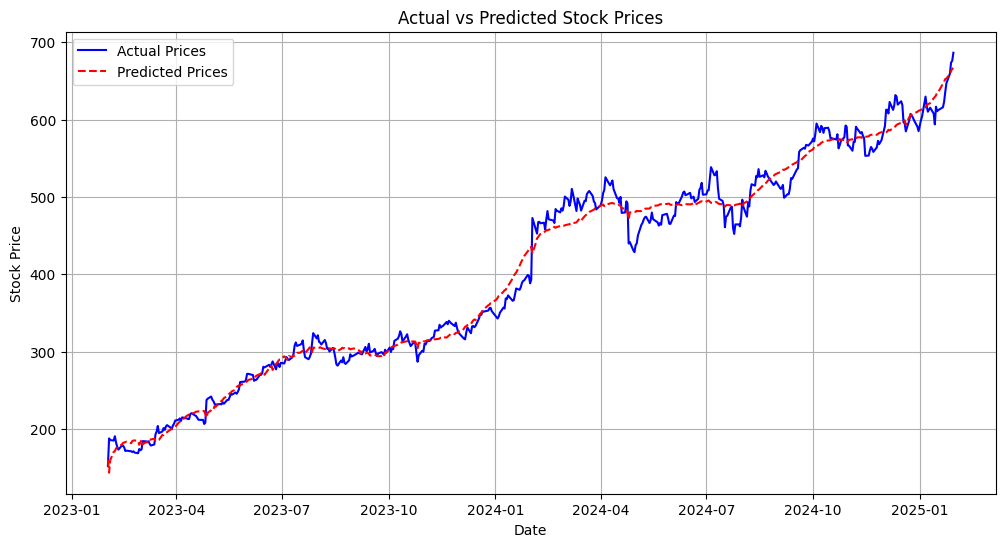

In [420]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(actual['Date'], forecast_test['yhat'], label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

### Model Evaluation Metrics Summary

This section provides the evaluation metrics for various regression models used in this analysis. The models include XGBoost Regressor, Random Forest Regressor, Support Vector Regressor (SVR), ARIMA, SARIMA, ARIMAX, SARIMAX, LSTM, and Prophet.

---

| **Model**                  | **Metric**                    | **Train**         | **Test**          |
|----------------------------|-------------------------------|-------------------|-------------------|
| **XGBoost Regressor**       | Mean Absolute Error (MAE)      | 280.670355        | 586.089271        |
|                            | Root Mean Squared Error (RMSE) | 299.579228        | 587.092123        |
|                            | R-squared (R²)                | -7.181312         | -292.226202       |
| **Random Forest Regressor** | Mean Absolute Error (MAE)      | 8.569185          | N/A               |
|                            | Root Mean Squared Error (RMSE) | 12.479988         | N/A               |
|                            | R-squared (R²)                | 0.991684          | N/A               |
| **SVR (Before Hyperparameter Tuning)** | R-squared (R²)        | 0.924250          | -3.747784         |
|                            | Mean Squared Error (MSE)      | 376.807724        | 56494.775414      |
| **SVR (After Hyperparameter Tuning)** | R-squared (R²)      | 0.997907          | 0.985762          |
|                            | Mean Squared Error (MSE)      | 10.698208         | 48.687911         |
| **SVR (After Feature Engineering)** | R-squared (R²)        | 0.996037          | 0.979678          |
|                            | Mean Absolute Error (MAE)     | 3.497304          | 5.973778          |
|                            | Mean Squared Error (MSE)      | 21.540833         | 59.186446         |
|                            | Root Mean Squared Error (RMSE)| 21.540833         | 59.186446         |
|                            | Explained Variance Score (EVS)| 0.996038          | 0.984647          |
| **ARIMA**                   | MAE                           | 4.865324          | 7.202944          |
|                            | MSE                           | 102.284154        | 652.884324        |
|                            | RMSE                          | 10.113563         | 25.551601         |
|                            | R-squared (R²)                | 0.981170          | 0.965141          |
| **SARIMA**                  | MAE                           | 5.170005          | 7.455355          |
|                            | MSE                           | 129.277520        | 660.333293        |
|                            | RMSE                          | 11.370027         | 25.696951         |
|                            | R-squared (R²)                | 0.976201          | 0.964744          |
| **ARIMAX**                  | MAE                           | 1.605723          | 2.417039          |
|                            | MSE                           | 4.400197          | 9.666662          |
|                            | RMSE                          | 2.097665          | 3.109126          |
|                            | R-squared (R²)                | 0.999102          | 0.998351          |
| **SARIMAX**                 | MAE                           | 1.616929          | 2.409005          |
|                            | MSE                           | 4.437591          | 9.699947          |
|                            | RMSE                          | 2.106559          | 3.114474          |
|                            | R-squared (R²)                | 0.999094          | 0.998345          |
| **LSTM (Before Hypertuning)** | MAE                        | 8.5647            | 17.9772           |
|                            | MSE                           | 135.2868          | 500.2827          |
|                            | RMSE                          | 11.6313           | 22.3670           |
|                            | R-squared (R²)                | 0.9754            | 0.8322            |
| **LSTM (After Hypertuning)** | MAE                          | 0.0234            | 0.0362            |
|                            | MSE                           | 0.0008            | 0.0021            |
|                            | RMSE                          | 0.0291            | 0.0454            |
|                            | R-squared (R²)                | 0.9448            | 0.7524            |
| **Prophet**                 | Mean Squared Error (MSE)       | N/A               | 1547.192549       |
|                            | Root Mean Squared Error (RMSE)| N/A               | 39.334369         |
|                            | Mean Absolute Error (MAE)     | N/A               | 30.70436          |
|                            | R-squared | N/A         | 0.9854173277246949|

---
